# Import the directories

In [ ]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd


def extract_run_data(path, base_dir=None, tags=("training/energy_real", "training/std_energy", "training/staggered_magnetization_abs")):
    """
    Load the latest TensorBoard event file in the given path and extract time-series data for each tag.
    Returns a dict suitable for aggregation into a DataFrame, with series as lists.
    """
    # A) Pick latest event file
    event_files = glob.glob(os.path.join(path, "events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {path}")

    latest_file = max(event_files, key=os.path.getmtime)

    # B) Extract run name (relative to some root)
    run_name = os.path.relpath(path, base_dir) if base_dir else path

    # C) Load tensor events
    ea = event_accumulator.EventAccumulator(latest_file, size_guidance={"tensors": 0})
    ea.Reload()

    available = ea.Tags().get("tensors", [])
    record = {"run_name": run_name}

    for tag in tags:
        if tag not in available:
            print(f"Warning: Tag '{tag}' not found in {latest_file}")
            record[tag] = []
            continue

        steps = []
        values = []

        for evt in ea.Tensors(tag):
            try:
                val = tf.make_ndarray(evt.tensor_proto).item()
            except Exception as e:
                print(f"Error decoding {tag} @ step {evt.step}: {e}")
                continue
            steps.append(evt.step)
            values.append(val)

        record[tag] = values
        if "steps" not in record:
            record["steps"] = steps

    return record


def batch_extract(paths, tags=("training/energy_real", "training/std_energy", "training/staggered_magnetization_abs")):
    """
    Apply extract_run_data to a list of run paths and return a combined DataFrame.
    """
    base_dir = os.path.commonpath(paths)
    results = []

    for p in paths:
        try:
            row = extract_run_data(p, base_dir=base_dir, tags=tags)
            results.append(row)
        except Exception as e:
            print(f"Skipping {p}: {e}")

    return pd.DataFrame(results)


2025-04-28 13:34:48.430667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 13:34:48.430728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 13:34:48.516971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 13:34:49.020497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 13:35:11.454285: W tensorflow/comp

In [4]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs = [ckpt for ckpt in run_dirs if re.search(r'04_04', ckpt)]
checkpoint_dirs = [f"{path}checkpoints" for path in filtered_dirs]

n_sites = 16   # for 4×4
n_samples = 5_000   # number of MC samples to draw per run
thermalization = 500 * n_sites

df_runs = batch_extract(filtered_dirs,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

In [6]:
import numpy as np
# Step 1: Decode byte strings to regular strings
df_runs['config_str'] = df_runs['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs['seed'] = df_runs['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)
df_runs["final_energy"] = df_runs["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_std"]    = df_runs["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_stagg"]  = df_runs["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=1000
df_runs_seeded=df_runs[~df_runs['seed'].isna()]
df_runs_filtered = df_runs_seeded[df_runs_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


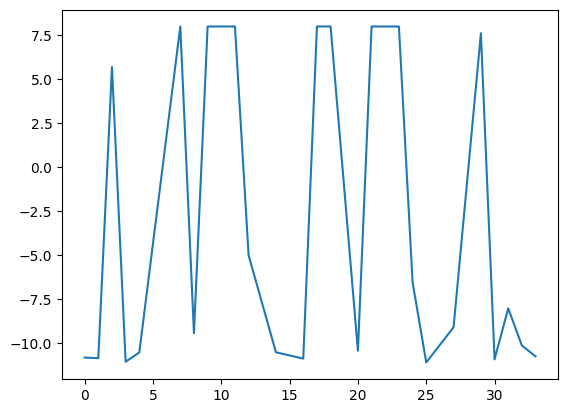

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_runs_seeded["final_energy"])

In [ ]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types


def safe_decode(x):
    try:
        return x.decode() if isinstance(x, bytes) else str(x)
    except: 
        return str(x) # Fallback

def extract_specific_hyperparams(config_str):
    hyperparams = {}
    # Regex to find specific parameters. Adjust patterns based on your config string format.
    beta_match = re.search(r'beta:\s*(\d+\.?\d*)', config_str)
    lr_match = re.search(r'learning_rate:\s*(\d+\.?\d*[eE]?-?\d*)', config_str)
    gnn_match = re.search(r'(GNN\d+adv|GNNprocnorm)_h\d+_e\d+_K\d+', config_str) # Example GNN architecture match

    hyperparams['beta'] = float(beta_match.group(1)) if beta_match else np.nan
    hyperparams['lr'] = float(lr_match.group(1)) if lr_match else np.nan

    return hyperparams
df_runs_seeded_copy= df_runs_seeded.copy()
# Apply extraction
df_runs_seeded_copy['config_str'] = df_runs_seeded_copy['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs_seeded_copy['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs_seeded_copy = pd.concat([df_runs_seeded_copy, hyperparams_df], axis=1)

# Filter out runs without seed or insufficient iterations
min_iterations = 1000
df_runs_seeded_copy_filtered = df_runs_seeded_copy[~df_runs_seeded_copy['seed'].isna()]
df_runs_seeded_copy_filtered = df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['training/energy_real'].apply(len) >= min_iterations].copy()

# Add final values
df_runs_seeded_copy_filtered["final_energy"] = df_runs_seeded_copy_filtered["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_std"]    = df_runs_seeded_copy_filtered["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_seeded_copy_filtered["final_stagg"]  = df_runs_seeded_copy_filtered["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)

print(f"Original runs: {len(df_runs_seeded_copy)}")
print(f"Runs after filtering (seed and >= {min_iterations} iterations): {len(df_runs_seeded_copy_filtered)}")

# Define exact values for 4x4
exact_energy = -11.228 # Your value from the plot
exact_stagg_abs = 0.517 # Your value from the plot

Original runs: 25
Runs after filtering (seed and >= 1000 iterations): 22


In [15]:
df_runs_seeded_copy_filtered_low_energy=df_runs_seeded_copy_filtered[df_runs_seeded_copy_filtered['final_energy'] < -10.8]
df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist()
# 3) filtro
dirs_lowE = [
    d for d in filtered_dirs
    if any(run in d for run in df_runs_seeded_copy_filtered_low_energy['run_name'].unique().tolist())
]

print(f"Trovate {len(dirs_lowE)} directory low-energy:" , dirs_lowE)

Trovate 6 directory low-energy: ['checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3', 'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1212x15_overlap_VMC/GNNprocnorm_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3', 'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2', 'checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1045x15_overlap_VMC/GNN2adv_h128_e64_K3']


## Check generalization on 6x6

In [232]:
import tensorflow as tf
import compgraph.tensorflow_version.model_loading
from compgraph.tensorflow_version.model_loading import check_and_reinitialize_model, load_model_from_path,extract_hyperparams_from_path
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt, precompute_graph_structure
import sonnet as snt
hyperparams=extract_hyperparams_from_path(dirs_lowE[0])
n_hyp,m_hyp=hyperparams.graph_params.n,hyperparams.graph_params.m
graph_larger,subl_larger=create_graph_from_ham(hyperparams.graph_params.graphType,(n_hyp+2,m_hyp+2)
                                 ,sublattice=hyperparams.graph_params.sublattice)
GT_Batch_init=initialize_graph_tuples_tf_opt(128, graph_larger, sublattice_encoding=subl_larger)

NameError: name 'dirs_lowE' is not defined

In [21]:
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel('ERROR')
models = {}
for idx, d in enumerate(dirs_lowE):
    ckpt_paths=sorted(glob.glob(d+'/checkpoints/*.index', recursive=True))
    ckpt_idxs = sorted(glob.glob(os.path.join(d, 'checkpoints', '*.index')))
    ckpt_path = ckpt_idxs[-2][:-6]   # rimuovo '.index'
    print("→ checkpoint:", ckpt_path)
    hyperparams=extract_hyperparams_from_path(ckpt_path)
    model_temp=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params,0)
    optimizer_temp=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
    # prova forward prima del caricamento
    _ = model_temp(GT_Batch_init)

    # carica pesi
    load_model_from_path(
        model=model_temp,
        checkpoint_path=ckpt_path,  # load_model cerca i file .index ecc qui
        optimizer=optimizer_temp
    )

    # verifica forward dopo
    psi_val = model_temp(GT_Batch_init)[0]
    print(f"✔ Caricato modello da {d}, psi_val[0]={psi_val}")

    # chiave unica: basename + beta + bs
    run_key = os.path.basename(d) +f"_b{hyperparams.sim_params.beta}_bs{hyperparams.sim_params.batch_size}_lr{hyperparams.sim_params.learning_rate}"+"_"+str(idx)
    models[run_key] = {
        "model": model_temp,
        "hyperparams": hyperparams
    }

print("\nModelli caricati:", list(models.keys()))

→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2/checkpoints/ckpt-8


2025-04-28 07:41:53.832889: I external/local_xla/xla/service/service.cc:168] XLA service 0x555568cf5be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 07:41:53.832922: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-28 07:41:55.717942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 07:41:56.412420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1745818920.491449  991912 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1745818920.506378  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_256lr1.0e-04_loop1210x30_overlap_VMC/GNNprocnorm_h128_e64_K2, psi_val[0]=[ 0.03339671 27.713573  ]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/ckpt-34


W0000 00:00:1745818931.097848  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1029x15_overlap_VMC/GNN2adv_h128_e64_K3, psi_val[0]=[ 5.1798053 25.120476 ]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1212x15_overlap_VMC/GNNprocnorm_h128_e64_K2/checkpoints/ckpt-26


W0000 00:00:1745818939.247456  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1212x15_overlap_VMC/GNNprocnorm_h128_e64_K2, psi_val[0]=[ 0.40129918 25.232838  ]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/ckpt-39


W0000 00:00:1745818948.762665  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3, psi_val[0]=[18.089035 26.036907]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2/checkpoints/ckpt-39


W0000 00:00:1745818958.409118  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2, psi_val[0]=[129.35338   25.901478]
→ checkpoint: checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1045x15_overlap_VMC/GNN2adv_h128_e64_K3/checkpoints/ckpt-30


W0000 00:00:1745818967.905022  991912 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


✔ Caricato modello da checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr7.0e-04_loop1045x15_overlap_VMC/GNN2adv_h128_e64_K3, psi_val[0]=[-1. -1.]

Modelli caricati: ['GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0', 'GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1', 'GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_2', 'GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0002_3', 'GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4', 'GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_5']


In [25]:

# 2b) Build checkerboard ε_i = ±1
eps_larger = np.array([1 if (x+y)%2==0 else -1
                for x in range(n_hyp+2) for y in range(m_hyp+2)])  # shape (16,)
eps_larger

array([ 1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1,
       -1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1,
       -1,  1])

In [31]:
from compgraph.monte_carlo import MCMCSampler
import time

sen, rec, edge_pairs=precompute_graph_structure(graph_larger)
GT_Batch_update=initialize_graph_tuples_tf_opt(128,graph_larger, sublattice_encoding=subl_larger)
template_graphs_output=initialize_graph_tuples_tf_opt(tf.shape(edge_pairs)[0]+1, graph_larger, sublattice_encoding=subl_larger)


In [33]:
spins_flat

<tf.Tensor: shape=(4608,), dtype=float32, numpy=array([ 1.,  1., -1., ...,  1.,  1.,  1.], dtype=float32)>

In [ ]:
n_sites6x6=36

In [38]:
def batch_staggered_metrics_pm1(spins_pm1, eps_pm1):
    """
    spins_pm1:  (B, N) tf.float32, values ±1
    eps_pm1:    (N,)   tf.float32, values ±1
    Returns dict with m_rms, m_abs, S_pp
    """
    spins = tf.convert_to_tensor(spins_pm1, tf.float32)     # (B,N)
    eps   = tf.convert_to_tensor(eps_pm1,   tf.float32)     # (N,)

    N     = tf.cast(tf.shape(spins)[1], tf.float32)         # 16 for 4×4
    Ms    = tf.reduce_sum(spins * eps[None,:], axis=1)      # (B,)

    Ms2   = tf.reduce_mean(tf.square(Ms))                   # ⟨Ms²⟩_batch
    m_rms = tf.sqrt(Ms2) / N
    m_abs = tf.reduce_mean(tf.abs(Ms)) / N
    S_pp  = Ms2 / N

    return m_rms, m_abs, S_pp


In [41]:
# results = {}
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
batch_size = 128
rows=[]
for run_key, data in models.items():
    model = data["model"]
    hyperparams = data["hyperparams"]
    if run_key=='GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_5':
        print("Skipping model:", run_key)
        continue
    GT_batch_temp=initialize_graph_tuples_tf_opt(batch_size, graph_larger, sublattice_encoding=subl_larger)

    print("model", run_key)
    print(model(GT_batch_temp)[82])  # Ensure model is initialized

    psi=model(GT_batch_temp)
    # 1) Initialize the graph
    initial_energy, std_initial,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_Batch_update,0)
    print("Initial energy:", initial_energy, 'std',std_initial)
    sampler_var_temp=MCMCSampler(GT_batch_temp)
    thermalization=200*n_sites6x6

    for i in range(thermalization):

        GT_batch_temp, psi=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)
    energy_after_term, std_after_term,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_batch_temp,0)

    print("Energy after:", energy_after_term, 'std',std_after_term)
    all_mrms = []
    all_mabs = []
    all_Spp  = []
    start_time=time.time()
    sampling=100*n_sites6x6

    for step in range(sampling):
        for j in range(n_sites6x6):
            GT_batch_temp, psi_new=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)
        spins_flat = GT_batch_temp.nodes[:,0]                  
        spins_2d    = tf.reshape(spins_flat, (batch_size, n_sites6x6))    

        # 4) Compute staggered metrics
        m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps_larger)
        all_mrms.append(m_rms.numpy())
        all_mabs.append(m_abs.numpy())
        all_Spp.append(S_pp.numpy())
        rows.append({
            "run":      run_key,
            "step":     step,
            "m_rms":    float(m_rms.numpy()),
            "m_abs":    float(m_abs.numpy()),
            "S_pp":     float(S_pp.numpy())
        })        
    print("Tempo per campionamento:", time.time()-start_time)    
# Costruisco il DataFrame unico
df_traj = pd.DataFrame(rows)
print(df_traj.head())        

model GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0
tf.Tensor([-0.59623235 25.860912  ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((1.6118553-1.0432657j), shape=(), dtype=complex64) std tf.Tensor(72.84829, shape=(), dtype=float32)
Energy after: tf.Tensor((-13.727803-0.2506571j), shape=(), dtype=complex64) std tf.Tensor(7.273982, shape=(), dtype=float32)
Tempo per campionamento: 1611.1393957138062
model GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1
tf.Tensor([-0.24406023 25.133621  ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-40.4038-60.923313j), shape=(), dtype=complex64) std tf.Tensor(675.8332, shape=(), dtype=float32)
Energy after: tf.Tensor((-8.6543865+0.43047458j), shape=(), dtype=complex64) std tf.Tensor(11.569722, shape=(), dtype=float32)
Tempo per campionamento: 1919.5177192687988
model GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_2
tf.Tensor([-0.27752876 26.980345  ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-29.026077+43.52302j), shape=(), d

In [46]:
df_traj

,run,step,m_rms,m_abs,S_pp
0,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,0,0.201329,0.148872,1.459201
1,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,1,0.202225,0.151910,1.472222
2,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,2,0.201568,0.152344,1.462674
3,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,3,0.219108,0.173177,1.728299
4,GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0,4,0.212799,0.162326,1.630208
...,...,...,...,...,...
17995,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4,3595,0.196664,0.154514,1.392361
17996,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4,3596,0.203296,0.165799,1.487847
17997,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4,3597,0.220425,0.177517,1.749132
17998,GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4,3598,0.214324,0.174913,1.653646


In [60]:
m_abs_quimb

0.517

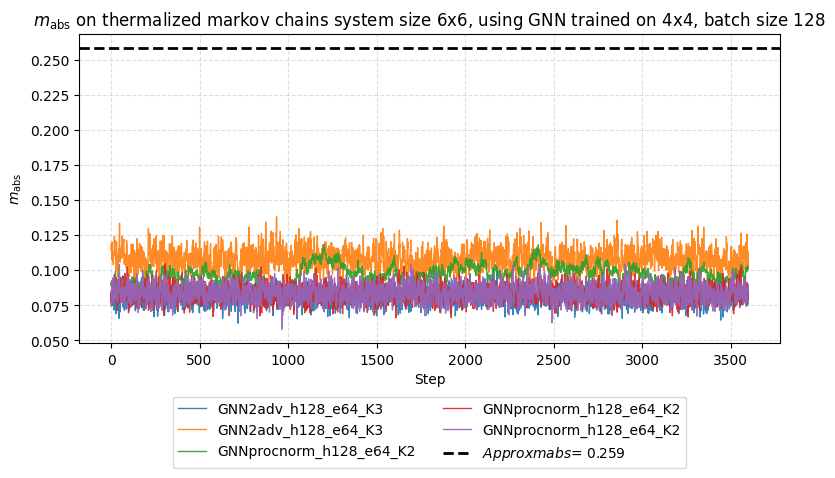

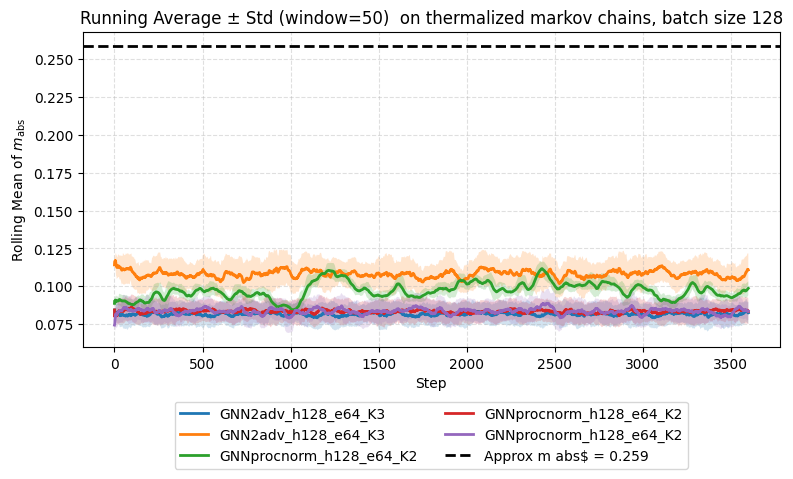

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
exact_energy_6x6 = -0.6783*36 
def abbrevia(key):
    m = re.match(r'^(.*?K.).*(.)$', key)
    if m:
        return f"{m.group(1)}"
    else:
        return key[:10] + "…" + key[-1]
# 2) Plot raw trajectories con legenda esterna
# 4. Plot delle traiettorie
fig, ax = plt.subplots(figsize=(8, 5))
for run_key, df_run in df_traj.groupby('run'):
    ax.plot(df_run['step'], df_run['m_abs']/2,
             alpha=0.9, linewidth=1, label=abbrevia(run_key))
    # 5. Linea orizzontale Quimb
ax.axhline(m_abs_quimb/2, color='k', linestyle='--', linewidth=2,
           label=f"$Approx m abs$= {m_abs_quimb/2:.3f}")
ax.set_xlabel('Step')
ax.set_ylabel(r'$m_\mathrm{abs}$')
ax.set_title('$m_{\\rm abs}$ on thermalized markov chains system size 6x6, using GNN trained on 4x4, batch size 128')
ax.grid(True, linestyle='--', alpha=0.4)
# Legenda sotto, 2 colonne (regola ncol in base al num. di run)
ax.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           frameon=True)

fig.tight_layout()
plt.show()

# # 7. Plot rolling mean ± std (facoltativo)
window = 50
fig, ax = plt.subplots(figsize=(8, 5))
for run_key, df_run in df_traj.groupby('run'):
    rm = df_run['m_abs'].rolling(window, min_periods=1).mean()/2
    rs = df_run['m_abs'].rolling(window, min_periods=1).std()/np.sqrt(2)

    ax.plot(df_run['step'], rm, linewidth=2, label=abbrevia(run_key))
    ax.fill_between(df_run['step'], rm - rs, rm + rs, alpha=0.2)

ax.axhline(m_abs_quimb/2, color='k', linestyle='--', linewidth=2,
           label=f"Approx m abs$ = {m_abs_quimb/2:.3f}")

ax.set_xlabel('Step')
ax.set_ylabel(r'Rolling Mean of $m_\mathrm{abs}$')
ax.set_title(f'Running Average ± Std (window={window})  on thermalized markov chains, batch size 128')
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.15),
          ncol=2,
          frameon=True)
fig.tight_layout()
plt.show()

In [53]:
# results = {}
from compgraph.tensorflow_version.hamiltonian_operations import stochastic_energy_tf
batch_size = 128
rows_energy=[]
for run_key, data in models.items():
    model = data["model"]
    hyperparams = data["hyperparams"]

    if run_key=='GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_5':
        print("Skipping model:", run_key)
        continue

    if run_key=='GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1':
        print("Skipping model:", run_key)
        continue

    if run_key=='GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0':
        print("Skipping model:", run_key)
        continue        
    
    
    GT_batch_temp=initialize_graph_tuples_tf_opt(batch_size, graph_larger, sublattice_encoding=subl_larger)

    print("model", run_key)
    print(model(GT_batch_temp)[82])  # Ensure model is initialized

    psi=model(GT_batch_temp)
    # 1) Initialize the graph
    initial_energy, std_initial,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_Batch_update,0)
    print("Initial energy:", initial_energy, 'std',std_initial)
    sampler_var_temp=MCMCSampler(GT_batch_temp)
    thermalization=200*n_sites6x6

    for i in range(thermalization):

        GT_batch_temp, psi=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)
    energy_after_term, std_after_term,_ =stochastic_energy_tf(psi, model, edge_pairs, template_graphs_output,GT_batch_temp,0)

    print("Energy after:", energy_after_term, 'std',std_after_term)
    en_std = []
    en_real = []
    en_imag  = []
    start_time=time.time()
    sampling=300

    for step in range(sampling):
        for j in range(n_sites6x6):
            GT_batch_temp, psi_new=sampler_var_temp.monte_carlo_update_on_batch_profilemem(model,GT_batch_temp)

        energy, std_energy,_ =stochastic_energy_tf(psi_new, model, edge_pairs, template_graphs_output,GT_batch_temp,0)

        # 4) Compute staggered metrics
        # m_rms, m_abs, S_pp = batch_staggered_metrics_pm1(spins_2d, eps_larger)
        en_std.append(tf.math.real(std_energy))
        en_real.append(tf.math.real(energy))
        en_imag.append(tf.math.imag(energy))
        rows_energy.append({
            "run":      run_key,
            "step":     step,
            "en_std":    float(tf.math.real(std_energy)),
            "en_real":    float(tf.math.real(energy)),
            "en_imag":     float(tf.math.imag(energy))
        })        
    print("Tempo per campionamento:", time.time()-start_time)    
# Costruisco il DataFrame unico
df_traj_energies = pd.DataFrame(rows_energy)
print(df_traj_energies.head())        

Skipping model: GNNprocnorm_h128_e64_K2_b0.07_bs256_lr0.0001_0
Skipping model: GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0007_1
model GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_2
tf.Tensor([ 2.6524606 21.77359  ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-11.721453+11.42965j), shape=(), dtype=complex64) std tf.Tensor(185.32596, shape=(), dtype=float32)
Energy after: tf.Tensor((-21.825968+0.095764324j), shape=(), dtype=complex64) std tf.Tensor(3.590872, shape=(), dtype=float32)
Tempo per campionamento: 401.87829995155334
model GNN2adv_h128_e64_K3_b0.007_bs128_lr0.0002_3
tf.Tensor([ 0.23041052 29.43553   ], shape=(2,), dtype=float32)
Initial energy: tf.Tensor((-46.80711-9.664225j), shape=(), dtype=complex64) std tf.Tensor(556.56525, shape=(), dtype=float32)
Energy after: tf.Tensor((-20.606632-0.07282876j), shape=(), dtype=complex64) std tf.Tensor(3.4439135, shape=(), dtype=float32)
Tempo per campionamento: 469.3162930011749
model GNNprocnorm_h128_e64_K2_b0.07_bs128_lr0.0001_4
t

In [ ]:
en_real_quimb=-36*

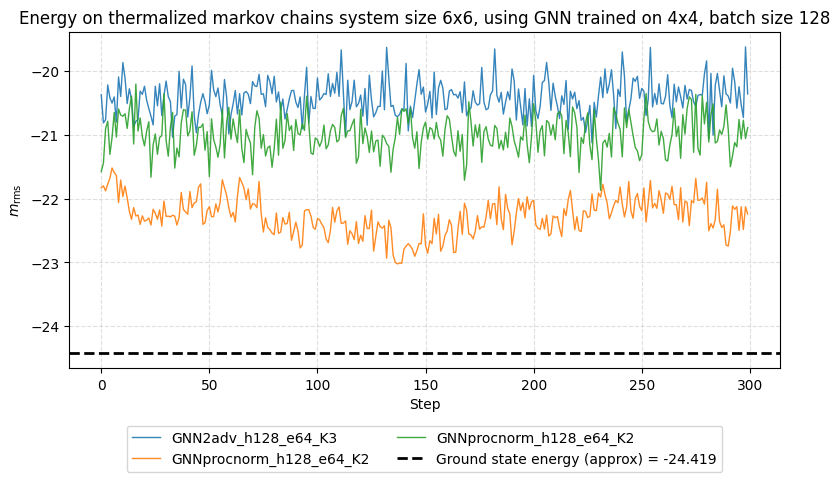

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
exact_energy_6x6 = -0.6783*36 
def abbrevia(key):
    m = re.match(r'^(.*?K.).*(.)$', key)
    if m:
        return f"{m.group(1)}"
    else:
        return key[:10] + "…" + key[-1]
# 2) Plot raw trajectories con legenda esterna
# 4. Plot delle traiettorie
fig, ax = plt.subplots(figsize=(8, 5))
for run_key, df_run in df_traj_energies.groupby('run'):
    ax.plot(df_run['step'], df_run['en_real'],
             alpha=0.9, linewidth=1, label=abbrevia(run_key))
    # 5. Linea orizzontale Quimb
ax.axhline(exact_energy_6x6, color='k', linestyle='--', linewidth=2,
           label=f"Ground state energy (approx) = {exact_energy_6x6:.3f}")
ax.set_xlabel('Step')
ax.set_ylabel(r'$m_\mathrm{rms}$')
ax.set_title('Energy on thermalized markov chains system size 6x6, using GNN trained on 4x4, batch size 128')
ax.grid(True, linestyle='--', alpha=0.4)
# Legenda sotto, 2 colonne (regola ncol in base al num. di run)
ax.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           frameon=True)

fig.tight_layout()
plt.show()
# plt.show()

# 6x6 

In [12]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs_6x6 = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs_6x6 = [ckpt for ckpt in run_dirs if re.search(r'06_06', ckpt)]
checkpoint_dirs_6x6 = [f"{path}checkpoints" for path in filtered_dirs]

n_sites_6x6 = 36   # for 4×4
thermalization_6x6 = 500 * n_sites

df_runs_6x6 = batch_extract(filtered_dirs_6x6,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

In [13]:
# Step 1: Decode byte strings to regular strings
df_runs_6x6['config_str'] = df_runs_6x6['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs_6x6['seed'] = df_runs_6x6['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)
df_runs_6x6["final_energy"] = df_runs_6x6["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6["final_std"]    = df_runs_6x6["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6["final_stagg"]  = df_runs_6x6["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=1000
df_runs_6x6_seeded=df_runs_6x6[~df_runs_6x6['seed'].isna()]
df_runs_6x6_filtered = df_runs_6x6_seeded[df_runs_6x6_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


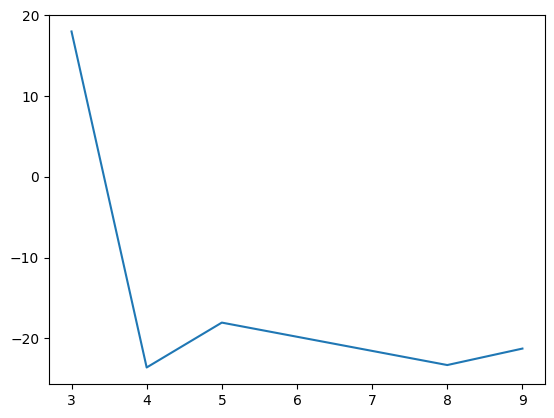

In [14]:
plt.plot(df_runs_6x6_seeded["final_energy"])

In [ ]:
import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types

df_runs_6x6_seeded_copy= df_runs_6x6_seeded.copy()
# Apply extraction
df_runs_6x6_seeded_copy['config_str'] = df_runs_6x6_seeded_copy['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs_6x6_seeded_copy['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs_6x6_seeded_copy = pd.concat([df_runs_6x6_seeded_copy, hyperparams_df], axis=1)

# Filter out runs without seed or insufficient iterations
min_iterations = 1000
df_runs_6x6_seeded_copy_filtered = df_runs_6x6_seeded_copy[~df_runs_6x6_seeded_copy['seed'].isna()]
df_runs_6x6_seeded_copy_filtered = df_runs_6x6_seeded_copy_filtered[df_runs_6x6_seeded_copy_filtered['training/energy_real'].apply(len) >= min_iterations].copy()

# Add final values
df_runs_6x6_seeded_copy_filtered["final_energy"] = df_runs_6x6_seeded_copy_filtered["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6_seeded_copy_filtered["final_std"]    = df_runs_6x6_seeded_copy_filtered["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_6x6_seeded_copy_filtered["final_stagg"]  = df_runs_6x6_seeded_copy_filtered["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)

print(f"Original runs: {len(df_runs_6x6_seeded_copy)}")
print(f"Runs after filtering (seed and >= {min_iterations} iterations): {len(df_runs_6x6_seeded_copy_filtered)}")

# Define exact values for 4x4
exact_energy_6x6 = -0.6783*36 # Your value from the plot
exact_stagg_abs_6x6 = 0.547 # Your value from the plot

# 3x3 

In [69]:
filtered_dirs_3x3

['checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.1__bs_64lr7.0e-05_loop1024x8_overlap_VMC/GNN2adv_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2__bs_128lr7.0e-05_loop1024x12_overlap_VMC/GNN2adv_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.007__bs_128lr1.0e-04_loop512x12_overlap_VMC/GNN2simple_h128_e64_K0',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.1__bs_256lr7.0e-05_loop512x8_overlap_VMC/GNN2adv_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.1__bs_128lr7.0e-04_loop1024x15_overlap_VMC/GNN2adv_h128_e64_K3',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.07__bs_128lr7.0e-05_loop256x18_overlap_VMC/GNN2adv_h128_e32_K1',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.07__bs_128lr7.0e-05_loop256x18_overlap_VMC/GNN2adv_h128_e64_K2',
 'checkpointed_logs/system_Heisenberg/2dsquare_03_03_Neel/beta0.2__bs_128lr7.0e-05_loop256x18_ove

In [68]:
import re
import glob
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)
run_dirs_3x3 = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs_3x3 = [ckpt for ckpt in run_dirs_3x3 if re.search(r'03_03', ckpt)]
checkpoint_dirs_3x3 = [f"{path}checkpoints" for path in filtered_dirs_3x3]

n_sites_3x3 = 9   # for 4×4
thermalization_3x3 = 500 * n_sites_3x3

# df_runs_3x3 = batch_extract(filtered_dirs_3x3,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
#                                               "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

# # Step 1: Decode byte strings to regular strings
# df_runs_3x3['config_str'] = df_runs_3x3['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))



In [8]:
import numpy as np
# Step 2: Extract seed if present
df_runs_3x3['seed'] = df_runs_3x3['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)
df_runs_3x3["final_energy"] = df_runs_3x3["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_3x3["final_std"]    = df_runs_3x3["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs_3x3["final_stagg"]  = df_runs_3x3["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
min_iterations=700
df_runs_3x3_seeded=df_runs_3x3[~df_runs_3x3['seed'].isna()]
df_runs_3x3_filtered = df_runs_3x3_seeded[df_runs_3x3_seeded['training/energy_real'].apply(len) >= min_iterations].copy()


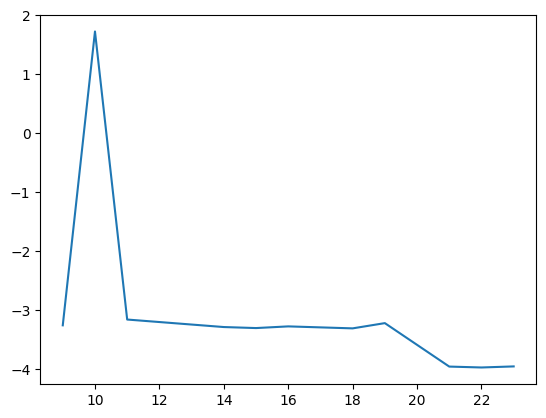

In [10]:
import matplotlib.pyplot as plt
plt.plot(df_runs_3x3_seeded["final_energy"])

In [ ]:
df_to_plot_3x3= df_runs_3x3_seeded[df_runs_3x3_seeded["final_energy"]<-2.9].copy()

# df_to_plot_3x3=df_runs_3x3_seeded[df_runs_3x3_seeded["final_energy"]<-3.6]

import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types


def safe_decode(x):
    try:
        return x.decode() if isinstance(x, bytes) else str(x)
    except: 
        return str(x) # Fallback

def extract_specific_hyperparams(config_str):
    hyperparams = {}
    # Regex to find specific parameters. Adjust patterns based on your config string format.
    beta_match = re.search(r'beta:\s*(\d+\.?\d*)', config_str)
    lr_match = re.search(r'learning_rate:\s*(\d+\.?\d*[eE]?-?\d*)', config_str)
    gnn_match = re.search(r'(GNN\d+adv|GNNprocnorm)_h\d+_e\d+_K\d+', config_str) # Example GNN architecture match

    hyperparams['beta'] = float(beta_match.group(1)) if beta_match else np.nan
    hyperparams['lr'] = float(lr_match.group(1)) if lr_match else np.nan

    return hyperparams
# Apply extraction
df_to_plot_3x3['config_str'] = df_to_plot_3x3['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_to_plot_3x3['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_to_plot_3x3 = pd.concat([df_to_plot_3x3, hyperparams_df], axis=1)


In [15]:
df_to_plot_3x3['run_name'].tolist()

,run_name,training/energy_real,training/std_energy,steps,training/staggered_magnetization_sqrt,training/staggered_magnetization_S_pp,training/staggered_magnetization_absv2,configuration/hyperparameters,config_str,seed,final_energy,final_std,final_stagg,beta,lr
9,2dsquare_03_03_Disordered/beta0.007__bs_128lr1...,"[4.485733985900879, 4.4371538162231445, 4.4738...","[0.03015713021159172, 0.06632804870605469, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.4006167948246002, 0.3888888955116272, 0.372...","[1.4444444179534912, 1.3611111640930176, 1.25,...","[0.3315972089767456, 0.3177083432674408, 0.302...",[b'beta: 0.007\nlearning_rate: 0.0001\nseed: 6...,[b'beta: 0.007\nlearning_rate: 0.0001\nseed: 6...,603779.0,-3.260126,0.050450,0.145833,0.007,0.0001
11,2dsquare_03_03_Disordered/beta0.07__bs_256lr1....,"[4.4586873054504395, 4.340978622436523, 4.4891...","[0.02669251337647438, 0.06492578983306885, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.3952847123146057, 0.4564354717731476, 0.319...","[1.40625, 1.875, 0.9201388955116272, 0.8333333...","[0.3255208432674408, 0.3793402910232544, 0.265...",[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 67...,[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 67...,673751.0,-3.161684,0.030687,0.332465,0.070,0.0001
14,2dsquare_03_03_Disordered/beta0.07__bs_64lr1.0...,"[4.063833713531494, 1.8714089393615723, 3.0664...","[0.1625523567199707, 0.2657564580440521, 0.261...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.31671538949012756, 0.30681556463241577, 0.3...","[0.9027777910232544, 0.8472222089767456, 1.222...","[0.2604166567325592, 0.25, 0.3090277910232544,...",[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 86...,[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 86...,860432.0,-3.289042,0.331506,0.114583,0.070,0.0001
15,2dsquare_03_03_Disordered/beta0.1__bs_64lr1.0e...,"[4.080925941467285, 1.6676701307296753, 3.4468...","[0.15219886600971222, 0.2914486825466156, 0.24...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.31426966190338135, 0.3263150155544281, 0.34...","[0.8888888955116272, 0.9583333134651184, 1.097...","[0.2673611044883728, 0.2604166567325592, 0.288...",[b'beta: 0.1\nlearning_rate: 0.0001\nseed: 860...,[b'beta: 0.1\nlearning_rate: 0.0001\nseed: 860...,860432.0,-3.306380,0.015050,0.111111,0.100,0.0001
16,2dsquare_03_03_Disordered/beta0.1__bs_64lr1.0e...,"[4.088201522827148, 1.8821207284927368, 3.3659...","[0.13946327567100525, 0.2677054703235626, 0.24...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.3643021285533905, 0.30681556463241577, 0.30...","[1.1944444179534912, 0.8472222089767456, 0.847...","[0.2951388955116272, 0.25, 0.2534722089767456,...",[b'beta: 0.1\nlearning_rate: 0.0001\nseed: 860...,[b'beta: 0.1\nlearning_rate: 0.0001\nseed: 860...,860432.0,-3.277880,0.023836,0.111111,0.100,0.0001
18,2dsquare_03_03_Disordered/beta0.07__bs_128lr1....,"[3.316133499145508, 0.6105800867080688, 1.9453...","[0.17176403105258942, 0.20389185845851898, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.33564016222953796, 0.3828902244567871, 0.39...","[1.0138888359069824, 1.3194444179534912, 1.395...","[0.28125, 0.3125, 0.3315972089767456, 0.277777...",[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 11...,[b'beta: 0.07\nlearning_rate: 0.0001\nseed: 11...,117791.0,-3.311497,0.006542,0.118056,0.070,0.0001
19,2dsquare_03_03_Disordered/beta0.07__bs_128lr2....,"[4.086862564086914, 0.6648010015487671, 3.6163...","[0.11171750724315643, 0.1903594434261322, 0.15...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.3513641953468323, 0.317931205034256, 0.3321...","[1.1111111640930176, 0.9097222089767456, 0.993...","[0.2881944477558136, 0.2604166567325592, 0.277...",[b'beta: 0.07\nlearning_rate: 0.0002\nseed: 86...,[b'beta: 0.07\nlearning_rate: 0.0002\nseed: 86...,860432.0,-3.222495,0.063303,0.131944,0.070,0.0002
21,2dsquare_03_03_Alternatepattern/beta0.1__bs_64...,"[3.8292996883392334, 2.0179405212402344, 2.703...","[0.17291519045829773, 0.26966

In [ ]:
	
system_Heisenberg/2dsquare_03_03_Alternatepattern/beta0.07__bs_128lr2.0e-04_loop1220x15_overlap_VMC/GNNprocnorm_h128_e64_K2

system_Heisenberg/2dsquare_03_03_Alternatepattern/beta0.1__bs_64lr1.0e-04_loop1220x15_overlap_VMC/GNNprocnorm_h128_e64_K2

system_Heisenberg/2dsquare_03_03_Disordered/beta0.07__bs_128lr2.0e-04_loop1221x15_overlap_VMC/GNNprocnorm_h128_e64_K2

system_Heisenberg/2dsquare_03_03_Disordered/beta0.1__bs_64lr1.0e-04_loop1221x15_overlap_VMC/GNNprocnorm_h128_e64_K

<Figure size 1400x1200 with 0 Axes>

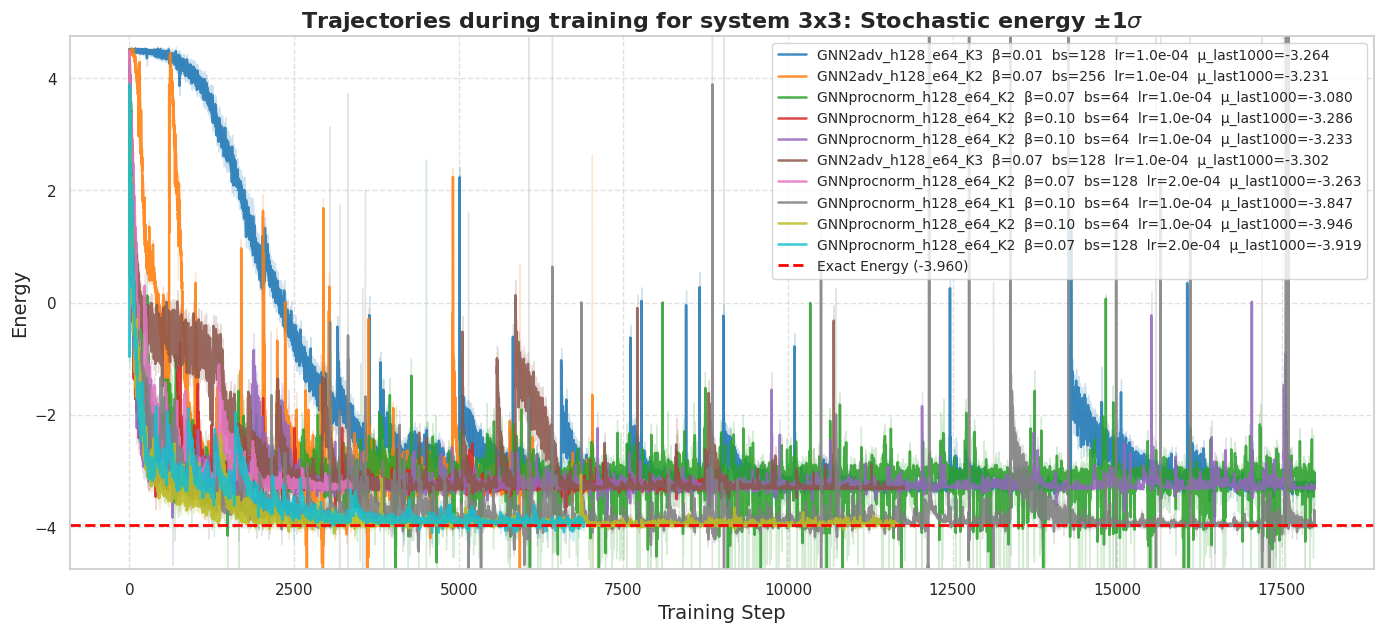

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
exact_energy = -3.96

# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Trajectories during training for system {3}x{3}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(df_to_plot_3x3))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(df_to_plot_3x3.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]

    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## Understanding graph coloring

In [1]:
import tensorflow as tf


2025-04-29 07:27:03.630917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 07:27:03.630986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 07:27:03.659145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 07:27:03.780245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 07:27:13.616999: W tensorflow/comp

In [ ]:
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_graph_tuples, initialize_hamiltonian_and_groundstate
graph, subl=create_graph_from_ham('2dsquare', (4, 4), sublattice='Alternatepattern')

In [31]:
graph, subl2=create_graph_from_ham('2dsquare', (4, 4), sublattice='Neel')

In [8]:
graph.nodes
graph.edges

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [12]:
gt=initialize_graph_tuples_tf_opt(1, graph, sublattice_encoding=subl)

In [21]:
gt.nodes[:,0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
        1., -1., -1.], dtype=float32)>

In [22]:
gt
spins = gt.nodes[:, 0]

spins_2d = tf.reshape(spins, (1, 4,4))
spins_2d

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[ 1., -1., -1., -1.],
        [ 1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1.],
        [-1.,  1., -1., -1.]]], dtype=float32)>

In [38]:
suba=gt.nodes[:, 1]
suba_2d = tf.reshape(suba, (1, 4,4))
suba_2d
subb=gt.nodes[:, 2]
subb_2d = tf.reshape(subb, (1, 4,4))
subb_2d

<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.]]], dtype=float32)>

In [26]:
import networkx as nx
import tensorflow as tf

def graph_tuple_to_networkx(graph_tuple):
    """Convert GraphsTuple to NetworkX graph for coloring check."""
    G = nx.Graph()
    senders = graph_tuple.senders.numpy()
    receivers = graph_tuple.receivers.numpy()
    edges = zip(senders, receivers)
    G.add_edges_from(edges)
    return G

def check_bipartite_coloring(graph_tuple):
    """Check bipartite coloring of a GraphsTuple."""
    G = graph_tuple_to_networkx(graph_tuple)
    try:
        coloring = nx.algorithms.bipartite.color(G)
    except nx.NetworkXError as e:
        print(f"Graph is not bipartite: {e}")
        return None

    # Map coloring to node list
    color_array = [coloring[i] for i in range(len(coloring))]
    print("Coloring found:", color_array)
    return color_array


In [30]:
check_bipartite_coloring(gt)

Coloring found: [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]


[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]

In [40]:

def generate_full_hilbert_space(num_sites, batch_size=1024):
    """Generator that yields the full basis batch by batch."""
    n_states = 2 ** num_sites
    indices = tf.range(n_states, dtype=tf.int32)

    for i in range(0, n_states, batch_size):
        batch_indices = indices[i:i+batch_size]
        # Create binary configs: each row is a bitstring
        configs = tf.bitwise.bitwise_and(
            tf.bitwise.right_shift(batch_indices[:, tf.newaxis],
                                   tf.range(num_sites, dtype=tf.int32)),
            1
        )
        configs = tf.cast(configs, tf.float32) * 2.0 - 1.0  # map {0,1} → {-1,+1}
        yield configs  # shape [batch_size, num_sites] or smaller at last batch



In [58]:
from compgraph.tensorflow_version.graph_tuple_manipulation import initialize_graph_tuples_tf_opt
graph, subl=create_graph_from_ham('2dsquare', (4, 4), sublattice='Alternatepattern')
bs= 1024
graph_dummy=initialize_graph_tuples_tf_opt(bs, graph, sublattice_encoding=subl)


In [ ]:
import re
# List of run directories containing TensorBoard events & checkpoints:
# all_checkpoints = glob.glob("checkpointed_logs/**/checkpoints", recursive=True)

run_dirs = glob.glob("checkpointed_logs/**/GNN*", recursive=True)

filtered_dirs = [ckpt for ckpt in run_dirs if re.search(r'04_04', ckpt)]
checkpoint_dirs = [f"{path}checkpoints" for path in filtered_dirs]

n_sites = 16   # for 4×4
n_samples = 5_000   # number of MC samples to draw per run
thermalization = 500 * n_sites

df_runs = batch_extract(filtered_dirs,  tags=("training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2","configuration/hyperparameters"))

import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel('ERROR')
models = {}
for idx, d in enumerate(dirs_lowE):
    ckpt_paths=sorted(glob.glob(d+'/checkpoints/*.index', recursive=True))
    ckpt_idxs = sorted(glob.glob(os.path.join(d, 'checkpoints', '*.index')))
    ckpt_path = ckpt_idxs[-2][:-6]   # rimuovo '.index'
    print("→ checkpoint:", ckpt_path)
    hyperparams=extract_hyperparams_from_path(ckpt_path)
    model_temp=initialize_NQS_model_fromhyperparams(hyperparams.ansatz, hyperparams.ansatz_params,0)
    optimizer_temp=snt.optimizers.Adam(hyperparams.sim_params.learning_rate,0.9,0.99)
    # prova forward prima del caricamento
    _ = model_temp(GT_Batch_init)

    # carica pesi
    load_model_from_path(
        model=model_temp,
        checkpoint_path=ckpt_path,  # load_model cerca i file .index ecc qui
        optimizer=optimizer_temp
    )

    # verifica forward dopo
    psi_val = model_temp(GT_Batch_init)[0]
    print(f"✔ Caricato modello da {d}, psi_val[0]={psi_val}")

    # chiave unica: basename + beta + bs
    run_key = os.path.basename(d) +f"_b{hyperparams.sim_params.beta}_bs{hyperparams.sim_params.batch_size}_lr{hyperparams.sim_params.learning_rate}"+"_"+str(idx)
    models[run_key] = {
        "model": model_temp,
        "hyperparams": hyperparams
    }

print("\nModelli caricati:", list(models.keys()))

In [57]:


for configs in generate_full_hilbert_space(16, batch_size=1024):
    print(configs)

    

tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]], shape=(1024, 16), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]], shape=(1024, 16), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]], shape=(1024, 16), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1. -1. ... -1. -1. -1.]
 ...
 [ 1. -1.  1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1. -1. -1.]
 [ 1.  1.  1. ... -1. -1. -1.]], shape=(1024, 16), dtype=float32)
tf.Tensor(
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1. -1. 

# Load data not visualizable on tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_energy(energy, E_exact, steps=None, title=None):
    """
    Plots stochastic energy vs training step, with a dashed line at E_exact.
    - energy: 1D array of energy values.
    - E_exact: scalar exact energy reference.
    - steps:   (optional) array of step indices (defaults to np.arange(len(energy))).
    - title:   (optional) chart title.
    """
    if steps is None:
        steps = np.arange(len(energy))

    plt.figure(figsize=(8,3))
    plt.plot(steps, energy, label="Stochastic E")
    plt.axhline(E_exact, color='k', linestyle='--', linewidth=1.5,
                label=f"Exact E ≃ {E_exact:.3f}")
    plt.xlabel("Training Step")
    plt.ylabel("Energy")
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_magnetization(mag, m_exact, steps=None, title=None):
    """
    Plots staggered magnetization vs training step, with a dashed line at m_exact.
    - mag:     1D array of |m| values.
    - m_exact: scalar exact |m| reference.
    - steps:   (optional) array of step indices.
    - title:   (optional) chart title.
    """
    if steps is None:
        steps = np.arange(len(mag))

    plt.figure(figsize=(8,3))
    plt.plot(steps, np.array(mag)/2, label="|m|")
    plt.axhline(m_exact/2, color='k', linestyle='--', linewidth=1.5,
                label=f"Exact |m| ≃ {m_exact/2:.3f}")
    plt.xlabel("Training Step")
    plt.ylabel("Staggered Magnetization")
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


def plot_deviation(mag, m_exact, energy, E_exact, steps=None, pct=False):
    """
    Plots 2×1 panels of deviation from exact:
      Top:   Δ|m|  = |mag - m_exact|  (or % if pct=True)
      Bottom: ΔE    = |energy - E_exact| (or % if pct=True)
    - mag, energy: arrays of same length.
    - m_exact, E_exact: scalars.
    - steps: optional array of the same length.
    - pct:   if True, show percentage deviation.
    """
    if steps is None:
        steps = np.arange(len(mag))

    if pct:
        dmag    = 100 * np.abs(mag    - m_exact) / np.abs(m_exact)
        dE      = 100 * np.abs(energy - E_exact) / np.abs(E_exact)
        ylabel1 = "% Δ|m|"
        ylabel2 = "% ΔE"
        title1  = "Magnetization %-Error"
        title2  = "Energy %-Error"
    else:
        dmag    = np.abs(mag    - m_exact)
        dE      = np.abs(energy - E_exact)
        ylabel1 = "Δ|m|"
        ylabel2 = "ΔE"
        title1  = "Deviation from Exact Magnetization"
        title2  = "Deviation from Exact Energy"

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(8,6))
    ax1.plot(steps, dmag,    label=ylabel1)
    ax1.set_ylabel(ylabel1)
    ax1.set_title(title1)
    ax1.legend(loc="upper right")

    ax2.plot(steps, dE, color='C1', label=ylabel2)
    ax2.set_ylabel(ylabel2)
    ax2.set_xlabel("Training Step")
    ax2.set_title(title2)
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


import numpy as np
import matplotlib.pyplot as plt

def plot_cross_correlation_pct(
    mag, m_exact,
    energy, E_exact,
    max_lag=200,
    title="Cross‐correlation vs Lag (M→E)",
    xlabel="Lag (steps): positive → Magnetization leads Energy",
    ylabel="Corr(%Δm, %ΔE)",
    figsize=(6,3)
):
    """
    Compute and plot cross‐correlation between percent‐errors of magnetization and energy,
    using the M→E convention (positive lag means M at t leads E at t+lag).
    """
    pct_m = 100 * np.abs(mag    - m_exact) / np.abs(m_exact)
    pct_e = 100 * np.abs(energy - E_exact) / np.abs(E_exact)

    lags = np.arange(-max_lag, max_lag+1)
    cc   = []
    for lag in lags:
        if lag < 0:
            # magnetization at t precedes energy by |lag|
            c = np.corrcoef(pct_m[:lag], pct_e[-lag:])[0,1]
        elif lag > 0:
            # magnetization at t follows energy by lag
            c = np.corrcoef(pct_m[lag:], pct_e[:-lag])[0,1]
        else:
            c = np.corrcoef(pct_m, pct_e)[0,1]
        cc.append(c)
    cc = np.array(cc)

    plt.figure(figsize=figsize)
    plt.plot(lags, cc, '.', ms=4)
    plt.axvline(0, color='k', lw=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return lags, cc


In [259]:
from simulation_analysis.load_from_paths import batch_extract_tf_events
import matplotlib.pyplot as plt
event_path_list =['/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.05__bs_256lr2.0e-04_loop1251x20_overlap_VMC/GNNprocnorm_h128_e64_K2',
                  '/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3',
                  '/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_04_04_Alternatepattern/beta0.05__bs_256lr2.0e-04_loop1221x40_overlap_VMC/GNNprocnorm_h128_e64_K2',
                  '/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1200x15_overlap_VMC/GNNprocnorm_h128_e64_K2',
                  '/home/s3378209/data1/repfin/thesis_MSc/checkpointed_logs/system_Heisenberg/2dsquare_04_04_Neel/beta0.07__bs_128lr1.0e-04_loop1212x15_overlap_VMC/GNNprocnorm_h128_e64_K2']


	
df_runs=batch_extract_tf_events(event_path_list, tags=["training/energy_real","training/std_energy","training/staggered_magnetization_sqrt",
                                              "training/staggered_magnetization_S_pp","training/staggered_magnetization_absv2",'configuration/hyperparameters'])
run_maybe_lost=df_runs.tail(1)


In [260]:
df_runs['config_str'] = df_runs['configuration/hyperparameters'].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Step 2: Extract seed if present
df_runs['seed'] = df_runs['config_str'].apply(
    lambda s: int(re.search(r'seed:\s*(\d+)', s).group(1)) if re.search(r'seed:\s*(\d+)', s) else np.nan
)
df_runs["final_energy"] = df_runs["training/energy_real"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_std"]    = df_runs["training/std_energy"].apply(lambda v: v[-1] if len(v)>0 else np.nan)
df_runs["final_stagg"]  = df_runs["training/staggered_magnetization_absv2"].apply(lambda v: v[-1] if len(v)>0 else np.nan)


In [262]:


import os, glob
from tensorboard.backend.event_processing import event_accumulator
from tensorboard.compat.proto import tensor_pb2
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns # for aesthetics and potentially different plot types


def safe_decode(x):
    try:
        return x.decode() if isinstance(x, bytes) else str(x)
    except: 
        return str(x) # Fallback

def extract_specific_hyperparams(config_str):
    hyperparams = {}
    # Regex to find specific parameters. Adjust patterns based on your config string format.
    beta_match = re.search(r'beta:\s*(\d+\.?\d*)', config_str)
    lr_match = re.search(r'learning_rate:\s*(\d+\.?\d*[eE]?-?\d*)', config_str)
    gnn_match = re.search(r'(GNN\d+adv|GNNprocnorm)_h\d+_e\d+_K\d+', config_str) # Example GNN architecture match

    hyperparams['beta'] = float(beta_match.group(1)) if beta_match else np.nan
    hyperparams['lr'] = float(lr_match.group(1)) if lr_match else np.nan

    return hyperparams
# Apply extraction
df_runs['config_str'] = df_runs['configuration/hyperparameters'].apply(safe_decode)
hyperparams_df = df_runs['config_str'].apply(lambda s: pd.Series(extract_specific_hyperparams(s)))
df_runs = pd.concat([df_runs, hyperparams_df], axis=1)


## Stoch energy during training

<Figure size 1400x1200 with 0 Axes>

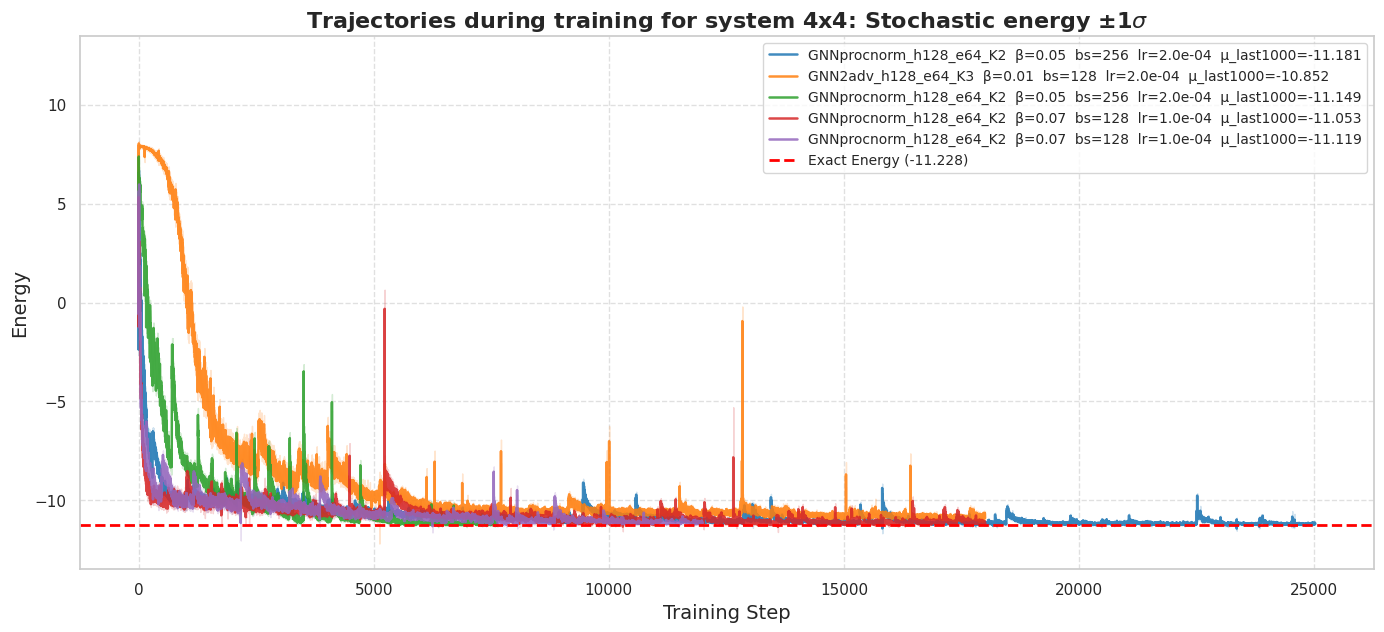

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
exact_energy = ge[0][0]

# Set seaborn style for prettier plots
sns.set_theme(style="whitegrid")

title_n=f"Trajectories during training for system {4}x{4}: Stochastic energy ±1" + r"$\sigma$"

plt.figure(figsize=(14, 12))

# calculate how far below exact_energy to clip
offset = 0.2 * abs(exact_energy)
ymin = exact_energy - offset

# get a categorical palette
palette = sns.color_palette("tab10", n_colors=len(df_runs))

plt.figure(figsize=(14, 12))
ax1 = plt.subplot(2, 1, 1)

for (idx, run_data), color in zip(df_runs.iterrows(), palette):
    steps       = np.array(run_data['steps'])
    energy      = np.array(run_data['training/energy_real'])
    std_energy  = np.array(run_data['training/std_energy'])
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()

    # extract a simpler run name
    run_name   = run_data.get('run_name', str(idx))
    m          = re.search(r'GNN\d+adv_h\d+_e\d+_K\d+', run_name)
    simple_name= m.group(0) if m else run_name.split('/')[-1]
    tail_length= 1000
    # 1. compute mean of last 300 points (or all if shorter)
    tail = energy[-tail_length:] if len(energy) >= tail_length else energy
    final_mean = tail.mean()
    # Extract batch size
    bs_match = re.search(r'__bs_(\d+)lr', run_name)
    if bs_match:
        batch_size = int(bs_match.group(1))
    else:
        batch_size = None  # fallback if not found

    # --- Build label including batch size ---
    label = f"{simple_name}  β={run_data['beta']:.2f}  bs={batch_size}  lr={run_data['lr']:.1e}  μ_last{len(tail)}={final_mean:.3f}"

    ax1.plot(steps, energy,
             label=label,
             color=color,
             linewidth=1.8,
             alpha=0.85)

    ax1.fill_between(steps,
                     energy - std_energy,
                     energy + std_energy,
                     color=color,
                     alpha=0.2)

# 3. exact energy line
ax1.axhline(y=exact_energy,
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Exact Energy ({exact_energy:.3f})')

# 4. clip y-axis to 20% below the ground truth
ax1.set_ylim(bottom=ymin,top=-ymin)
ax1.set_title(title_n, fontsize=16, fontweight='bold')
ax1.set_xlabel('Training Step', fontsize=14)
ax1.set_ylabel('Energy', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import quimb as qu
h_4x4=qu.ham_heis_2D(4,4, j=1.0, cyclic=True)
gs_4x4=qu.groundstate(h_4x4)
ge=gs_4x4.H@h_4x4@gs_4x4df_runs["training/energy_real"].iloc[5000:]

In [185]:
df_runs["training/energy_real"].iloc[0:]

0    [5.755333423614502, -2.3815431594848633, 4.372...
1    [7.873477458953857, 4.6312456130981445, 7.4073...
Name: training/energy_real, dtype: object

In [202]:
df_runs.iloc[1]['run_name']

'beta0.007__bs_128lr2.0e-04_loop1200x15_overlap_VMC/GNN2adv_h128_e64_K3'

In [209]:
quimb_rms, quimb_m_stagg_abs, S_pp_quimb=staggered_magnetization_quimb(4,4, gs_4x4)

Quimb baseline: 0.6072090646153085 0.5173775227073766 5.8992455704159665


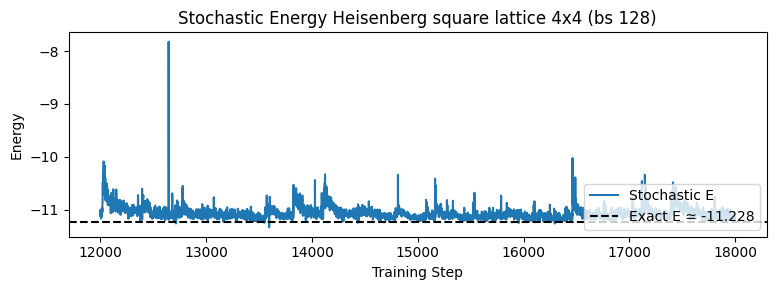

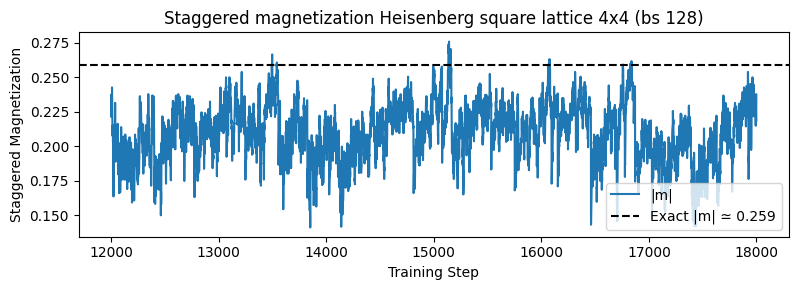

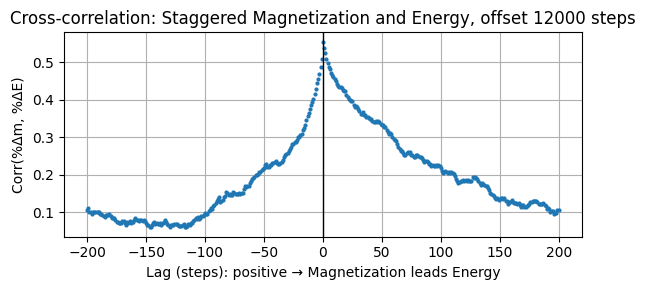

(array([-200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190,
        -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179,
        -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168,
        -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
        -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146,
        -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135,
        -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124,
        -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113,
        -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102,
        -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,
         -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,
         -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,
         -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,
         -57,  -56,  -55,  -54,  -53, 

In [257]:
offset_training=12000
idx_run=3

plot_energy(energy=df_runs.iloc[idx_run]["training/energy_real"][offset_training:], E_exact=ge[0][0], steps=df_runs.iloc[idx_run]["steps"][offset_training:], 
            title="Stochastic Energy Heisenberg square lattice 4x4 (bs 128)")
plot_magnetization(mag=df_runs.iloc[idx_run]["training/staggered_magnetization_absv2"][offset_training:],
                    m_exact=quimb_m_stagg_abs, steps=df_runs.iloc[idx_run]["steps"][offset_training:],
                      title="Staggered magnetization Heisenberg square lattice 4x4 (bs 128)")
plot_cross_correlation_pct(
    mag=df_runs.iloc[idx_run]["training/staggered_magnetization_absv2"][offset_training:],
    m_exact=quimb_m_stagg_abs,
    energy=df_runs.iloc[idx_run]["training/energy_real"][offset_training:],
    E_exact=ge[0][0],
    max_lag=200,
    title=f"Cross‐correlation: Staggered Magnetization and Energy, offset {offset_training} steps",)

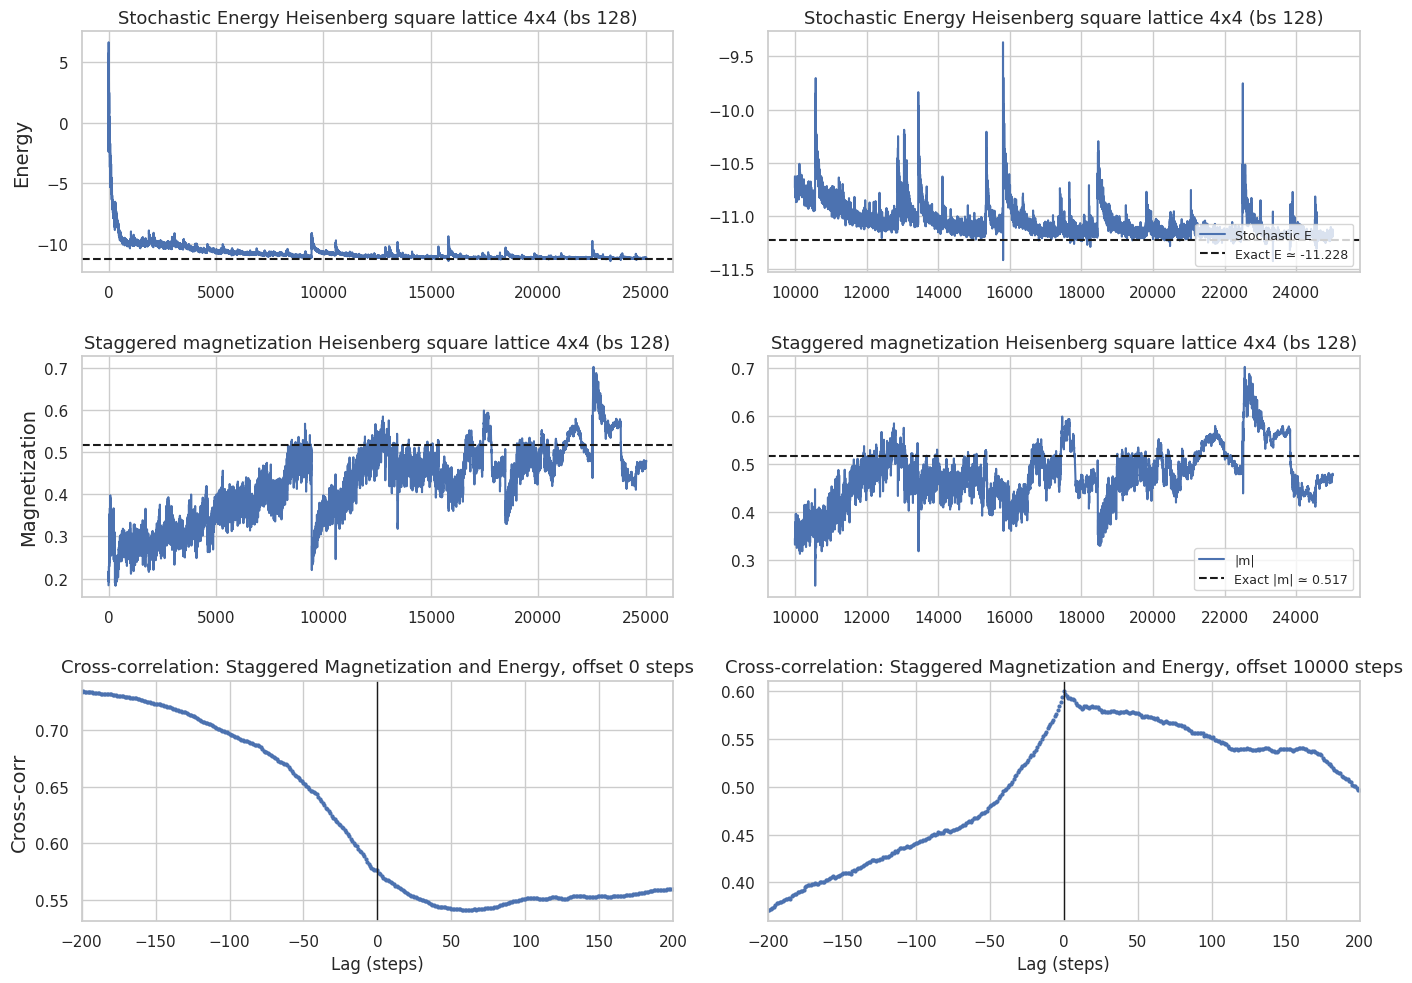

In [277]:
import numpy as np
import matplotlib.pyplot as plt

offset_training = 10000
idx_run         = 0

# Extract the raw arrays once
run = df_runs.iloc[idx_run]
steps_full  = run["steps"]
energy_full = run["training/energy_real"]
mag_full    = run["training/staggered_magnetization_absv2"]

# Exact references
E_exact = ge[0][0]
m_exact = quimb_m_stagg_abs

# Titles you supplied
energy_titles = [
    "Stochastic Energy Heisenberg square lattice 4x4 (bs 128)",
    "Stochastic Energy Heisenberg square lattice 4x4 (bs 128)"
]
mag_titles = [
    "Staggered magnetization Heisenberg square lattice 4x4 (bs 128)",
    "Staggered magnetization Heisenberg square lattice 4x4 (bs 128)"
]
cross_titles = [
    "Cross‐correlation: Staggered Magnetization and Energy, offset 0 steps",
    f"Cross‐correlation: Staggered Magnetization and Energy, offset {offset_training} steps"
]

# Build the grid
fig, axes = plt.subplots(3, 2, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 1, 1]})

for col, offset in enumerate([0, offset_training]):
    steps  = np.arange(offset, len(steps_full))
    energy = energy_full[offset:]
    mag    = mag_full[offset:]

    # 1) Energy plot
    ax = axes[0, col]
    ax.plot(steps, energy, label="Stochastic E")
    ax.axhline(E_exact, color='k', ls='--', lw=1.5,
               label=f"Exact E ≃ {E_exact:.3f}")
    ax.set_title(energy_titles[col], fontsize=13)
    if col == 0:
        ax.set_ylabel("Energy")
    if col == 1:
        ax.legend(loc="lower right", fontsize=9)
    ax.grid(True)

    # 2) Magnetization plot
    ax = axes[1, col]
    ax.plot(steps, mag, label="|m|")
    ax.axhline(m_exact, color='k', ls='--', lw=1.5,
               label=f"Exact |m| ≃ {m_exact:.3f}")
    ax.set_title(mag_titles[col], fontsize=13)
    if col == 0:
        ax.set_ylabel("Magnetization")
    if col == 1:
        ax.legend(loc="lower right", fontsize=9)
    ax.grid(True)

    # 3) Cross‐correlation plot
    pct_m = 100 * np.abs(mag    - m_exact) / np.abs(m_exact)
    pct_e = 100 * np.abs(energy - E_exact) / np.abs(E_exact)
    max_lag = 200
    lags = np.arange(-max_lag, max_lag+1)
    cc = []
    for lag in lags:
        if lag < 0:
            c = np.corrcoef(pct_m[:lag], pct_e[-lag:])[0,1]
        elif lag > 0:
            c = np.corrcoef(pct_m[lag:], pct_e[:-lag])[0,1]
        else:
            c = np.corrcoef(pct_m, pct_e)[0,1]
        cc.append(c)
    cc = np.array(cc)

    ax = axes[2, col]
    ax.plot(lags, cc, '.', ms=4)
    ax.axvline(0, color='k', lw=1)
    ax.set_xlim(-max_lag, max_lag)
    ax.set_title(cross_titles[col], fontsize=13)
    ax.set_xlabel("Lag (steps)")
    if col == 0:
        ax.set_ylabel("Corr(%Δm, %ΔE)")
    ax.grid(True)

# Label rows
for row, label in enumerate(["Energy", "Magnetization", "Cross-corr"]):
    axes[row, 0].set_ylabel(label, fontsize=14)

plt.tight_layout(h_pad=2.0, w_pad=2.0)
plt.show()


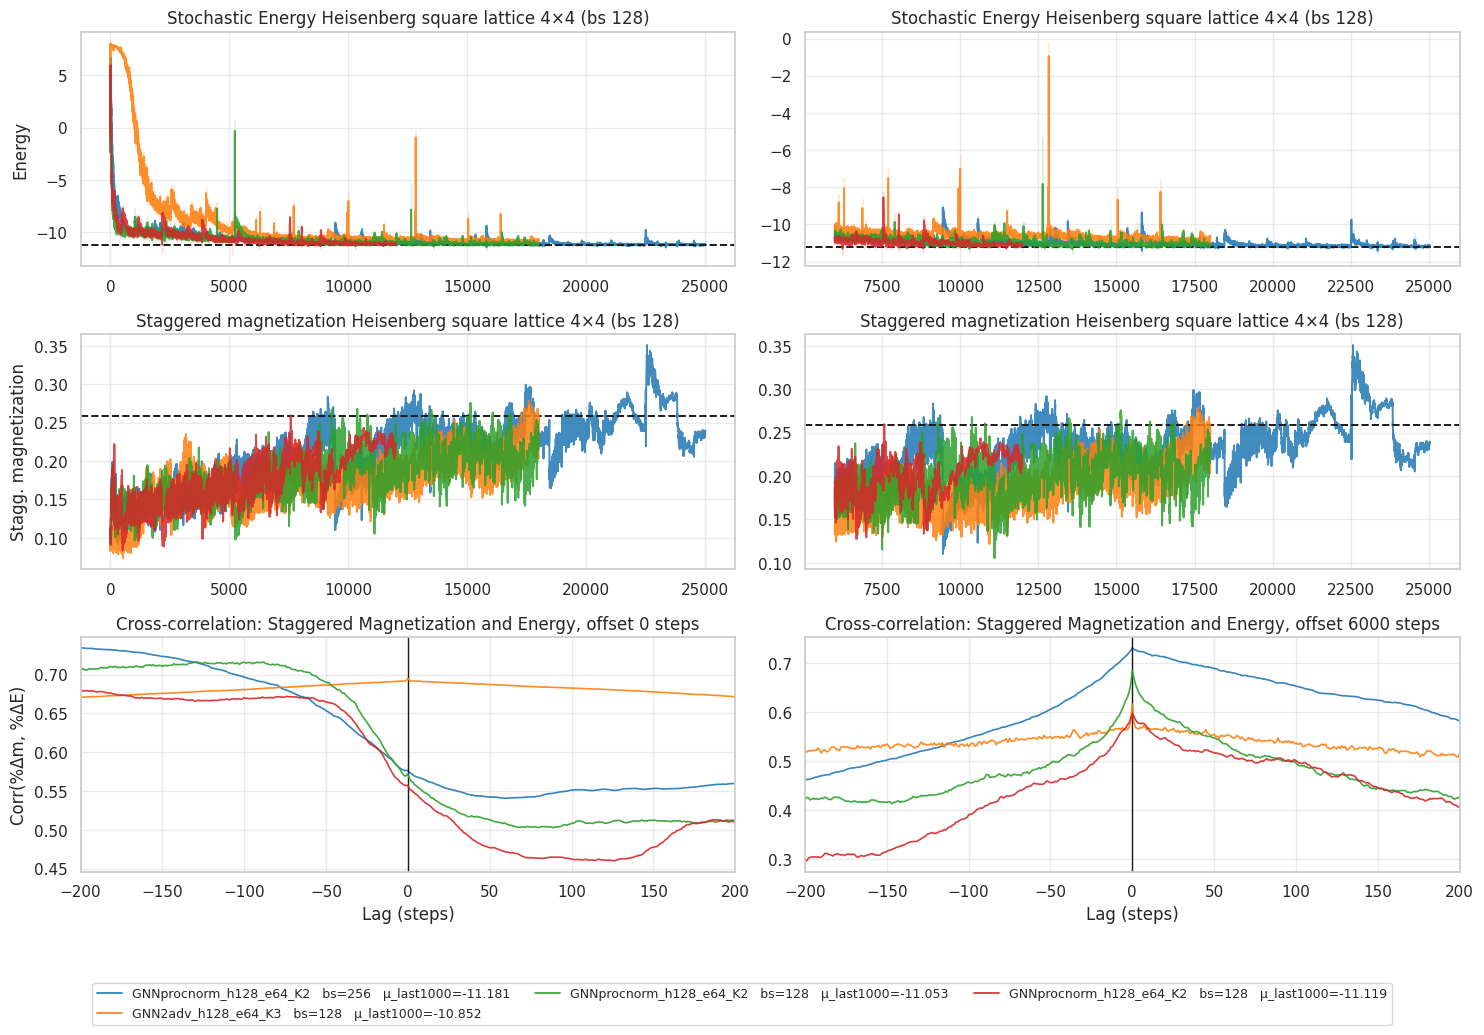

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_multi_runs_3x2(df_runs, run_indices, offset_training,
                        E_exact, m_exact,
                        max_lag=200, show_sigma=False):
    """
    3 × 2 panel:          full-run (col-0) | offset-run (col-1)
           row-0  energy
           row-1  magnetization
           row-2  cross-corr (%Δm , %ΔE)

    df_runs      : your dataframe
    run_indices  : list/tuple of row numbers to plot
    offset_training : int, starting step of the second column
    E_exact, m_exact: reference values
    """
    m_exact/=2
    # ── styling ────────────────────────────────────────────────
    colours = plt.cm.tab10.colors
    fig, axes = plt.subplots(3, 2, figsize=(15, 10),
                             gridspec_kw={'height_ratios':[1,1,1]})

    titles_row0 = ["Stochastic Energy Heisenberg square lattice 4×4 (bs 128)",
                   "Stochastic Energy Heisenberg square lattice 4×4 (bs 128)"]
    titles_row1 = ["Staggered magnetization Heisenberg square lattice 4×4 (bs 128)",
                   "Staggered magnetization Heisenberg square lattice 4×4 (bs 128)"]
    titles_row2 = [f"Cross-correlation: Staggered Magnetization and Energy, offset 0 steps",
                   f"Cross-correlation: Staggered Magnetization and Energy, offset {offset_training} steps"]

    # iterate through runs
    for i, idx in enumerate(run_indices):
        colour = colours[i % len(colours)]
        run    = df_runs.iloc[idx]
        run_name = run.get("run_name", str(idx))
        simple  = re.search(r'GNN(?:\d+adv)?_h\d+_e\d+_K\d+', run_name)
        simple_name   = simple.group(0) if simple else run_name.split('/')[-1]
    # simple_name= m.group(0) if m else 
        

        steps_all  = np.asarray(run["steps"])
        energy_all = np.asarray(run["training/energy_real"])
        mag_all    = np.asarray(run["training/staggered_magnetization_absv2"])/2
        if show_sigma and "training/std_energy" in run:
            std_all = np.asarray(run["training/std_energy"])
        else:
            std_all = None
        tail_length= 1000
        # 1. compute mean of last 300 points (or all if shorter)
        tail = energy_all[-tail_length:] if len(energy_all) >= tail_length else energy_all
        final_mean = tail.mean()
        # Extract batch size
        bs_match = re.search(r'__bs_(\d+)lr', run_name)
        if bs_match:
            batch_size = int(bs_match.group(1))
        else:
            batch_size = None  # fallback if not found        
        label = f"{simple_name}   bs={batch_size}   μ_last{len(tail)}={final_mean:.3f}"

        # --- two columns: col=0 (full)  col=1 (offset) ----------
        for col, offset in enumerate([0, offset_training]):
            steps  = steps_all[offset:]
            energy = energy_all[offset:]
            mag    = mag_all[offset:]
            std    = std_all[offset:] if std_all is not None else None

            # ── ENERGY ──────────────────────────────────────────
            axE = axes[0, col]
            axE.plot(steps, energy, color=colour, label=label, alpha=0.85, lw=1.4)
            if std is not None and show_sigma:
                axE.fill_between(steps, energy-std, energy+std,
                                 color=colour, alpha=0.15)
            if i == 0:                       # only once
                axE.axhline(E_exact, ls='--', lw=1.4, color='k')
                axE.set_title(titles_row0[col], fontsize=12)
                axE.set_ylabel("Energy" if col==0 else "")
                axE.grid(True, alpha=0.4)

            # --- MAGNETIZATION ---------------------------------
            axM = axes[1, col]
            axM.plot(steps, mag, color=colour, alpha=0.85, lw=1.4)
            if i == 0:
                axM.axhline(m_exact, ls='--', lw=1.4, color='k')
                axM.set_title(titles_row1[col], fontsize=12)
                axM.set_ylabel("Stagg. magnetization" if col==0 else "")
                axM.grid(True, alpha=0.4)

            # --- CROSS-CORRELATION -----------------------------
            pct_e = 100*np.abs(energy - E_exact)/abs(E_exact)
            pct_m = 100*np.abs(mag    - m_exact)/abs(m_exact)
            lags  = np.arange(-max_lag, max_lag+1)
            cc    = np.empty_like(lags, dtype=float)
            for k, lag in enumerate(lags):
                if   lag < 0: cc[k] = np.corrcoef(pct_m[:lag],  pct_e[-lag:])[0,1]
                elif lag > 0: cc[k] = np.corrcoef(pct_m[lag:], pct_e[:-lag])[0,1]
                else:         cc[k] = np.corrcoef(pct_m, pct_e)[0,1]

            axC = axes[2, col]
            axC.plot(lags, cc, color=colour, lw=1.2, alpha=0.9)
            if i == 0:
                axC.set_title(titles_row2[col], fontsize=12)
                axC.set_xlim(-max_lag, max_lag)
                axC.axvline(0, color='k', lw=1)
                axC.set_xlabel("Lag (steps)")
                axC.set_ylabel("Corr(%Δm, %ΔE)" if col==0 else "")
                axC.grid(True, alpha=0.4)

    # shared legend --------------------------------------------------
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center',
               bbox_to_anchor=(0.5, -0.04), ncol=min(3,len(labels)), fontsize=9)

    plt.tight_layout(rect=[0, 0.05, 1, 1])   # leave room for legend
    plt.show()


# ─── HOW TO CALL ────────────────────────────────────────────────────
offset_training = 6000           # the shift that defines column-2
run_indices     = [0, 1,3,4]       # whichever rows you want to overlay

plot_multi_runs_3x2(
    df_runs,
    run_indices      = run_indices,
    offset_training  = offset_training,
    E_exact          = ge[0][0],
    m_exact          = quimb_m_stagg_abs,
    max_lag          = 200,
    show_sigma       = True        # set False if you don’t log std
    )


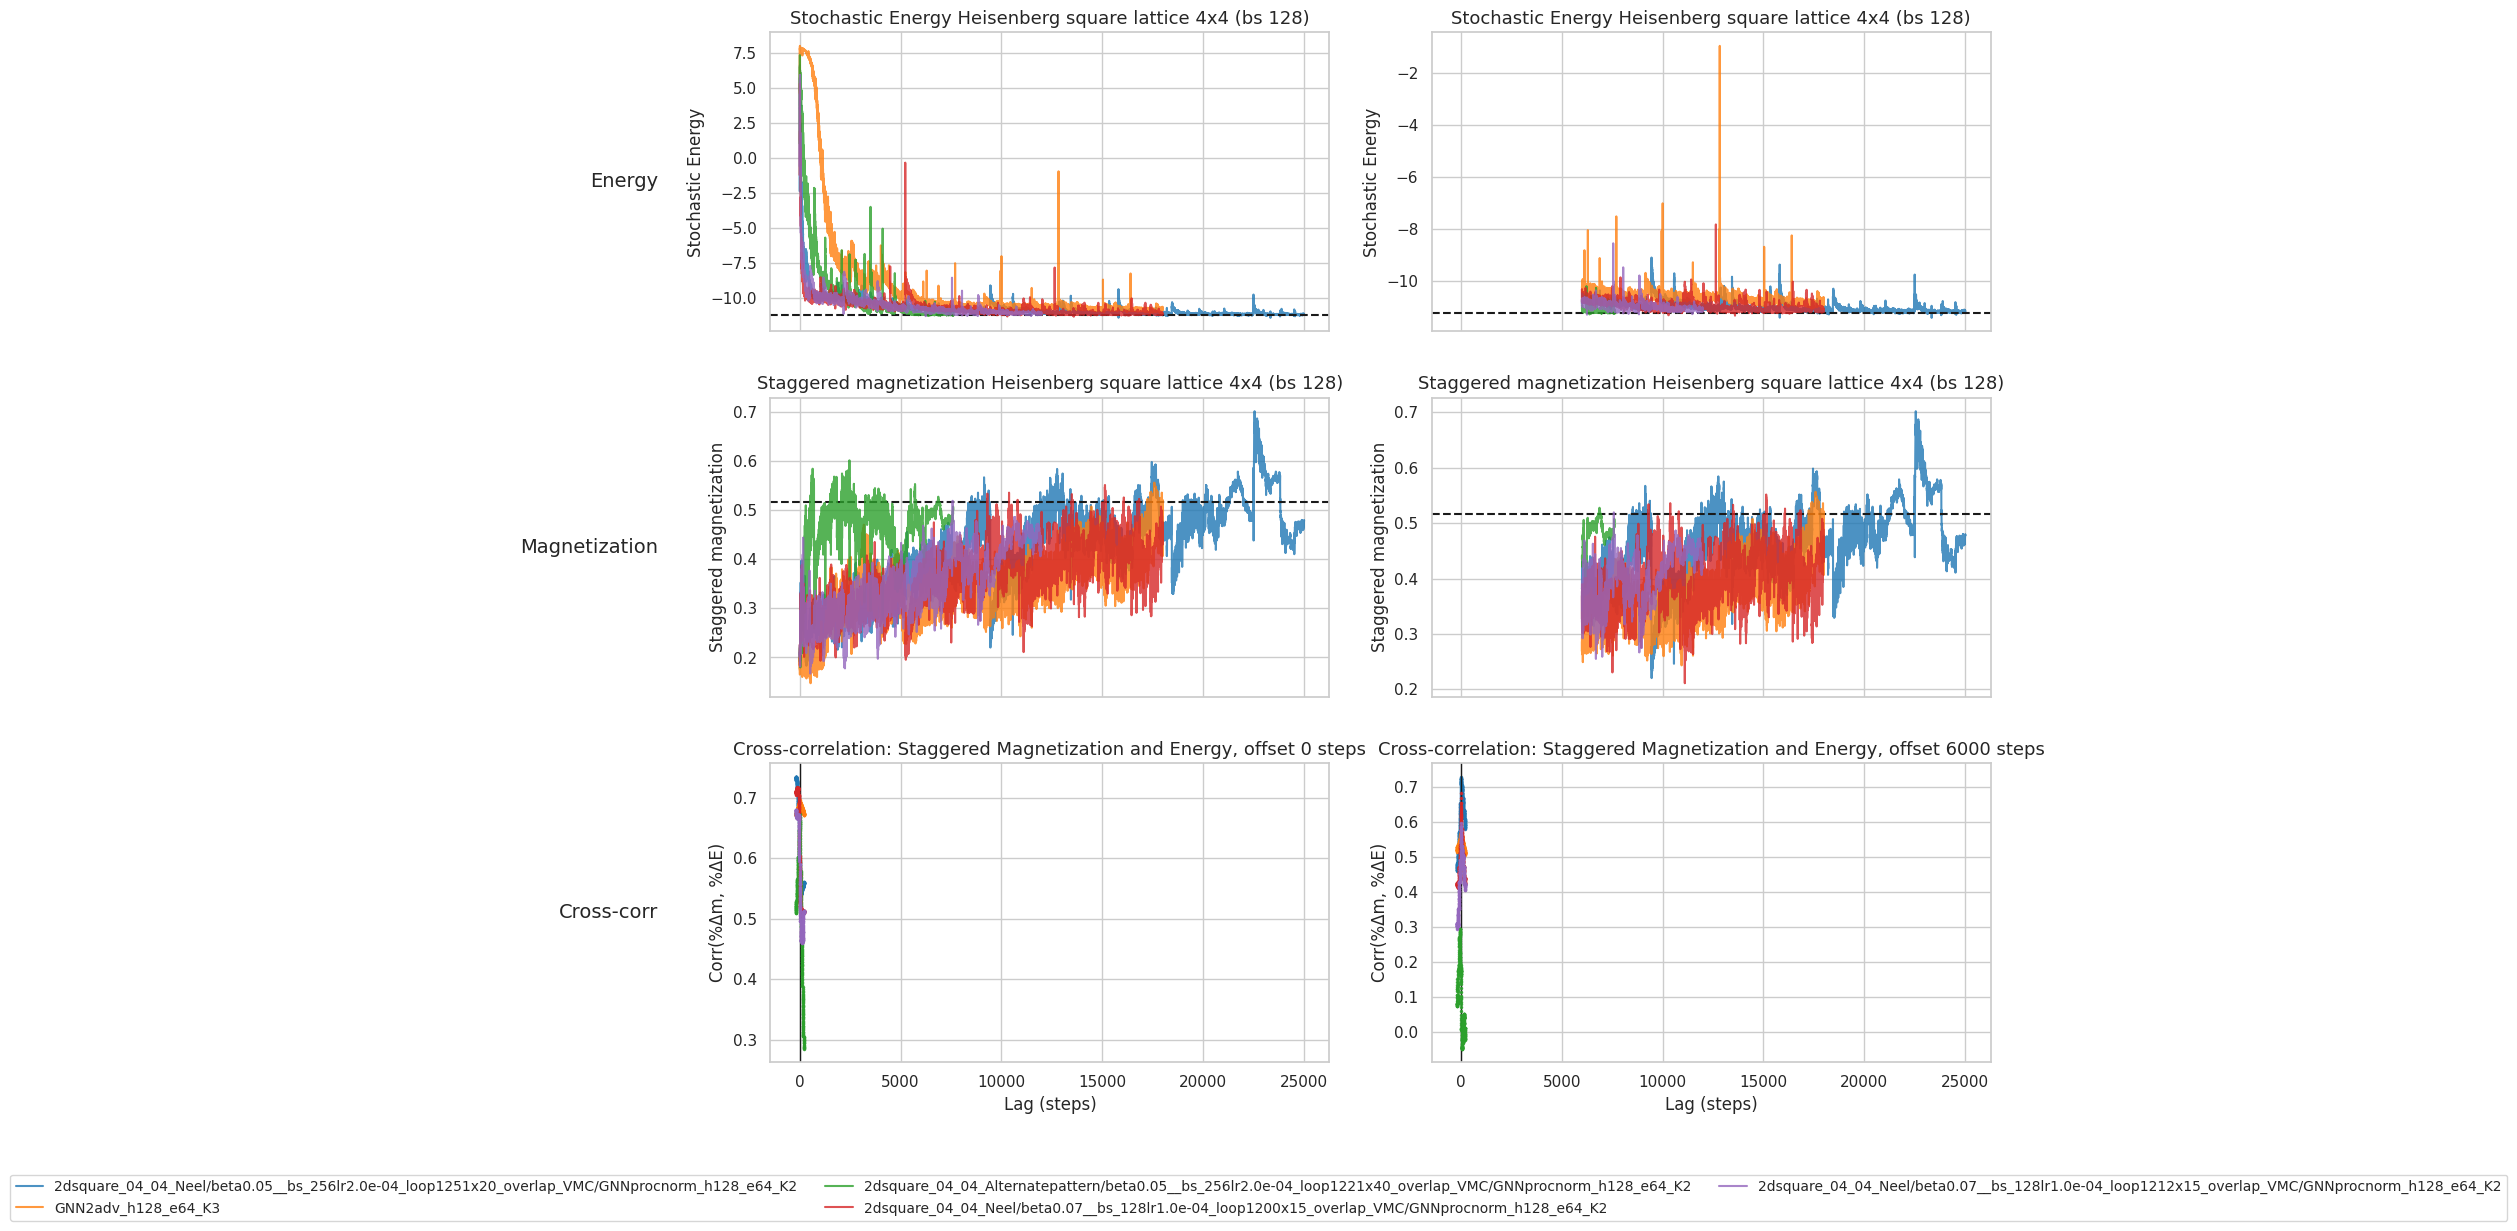

In [299]:
offset_training = 6000
run_indices = [0, 1, 2, 3, 4]  # Example indices you want to compare

plot_comparison_multiple_runs(
    df_runs,
    run_indices=run_indices,
    offset_training=offset_training,
    E_exact=ge[0][0],
    m_exact=quimb_m_stagg_abs
)


In [126]:
import importlib
import compgraph.quimb_helpers.operators
importlib.reload(compgraph.quimb_helpers.operators)
from compgraph.quimb_helpers.operators import staggered_magnetization_quimb

In [130]:
quimb_rms, quimb_m_stagg_abs, S_pp_quimb=staggered_magnetization_quimb(4,4, gs_4x4)

Quimb baseline: 0.6072090646153085 0.5173775227073766 5.8992455704159665


Text(0, 0.5, 'Stochastic Energy')

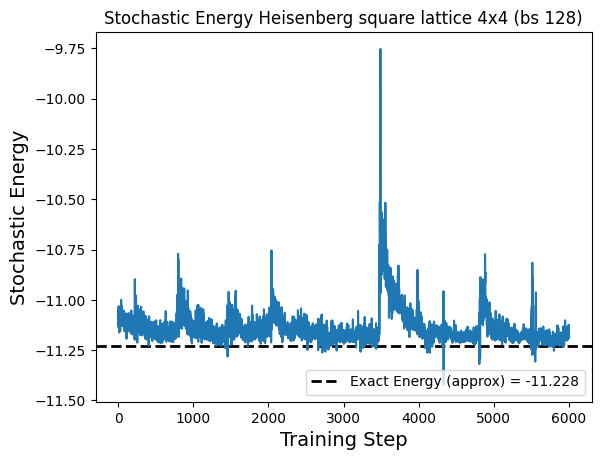

In [176]:
plt.title("Stochastic Energy Heisenberg square lattice 4x4 (bs 128)")

plt.axhline(ge[0][0], color='k', linestyle='--', linewidth=2,
           label=f"Exact Energy (approx) = {ge[0][0]:.3f}")
plt.plot(run_maybe_lost['training/energy_real'].values[0][-6000:])
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Stochastic Energy', fontsize=14)

Text(0, 0.5, 'Staggered magnetization')

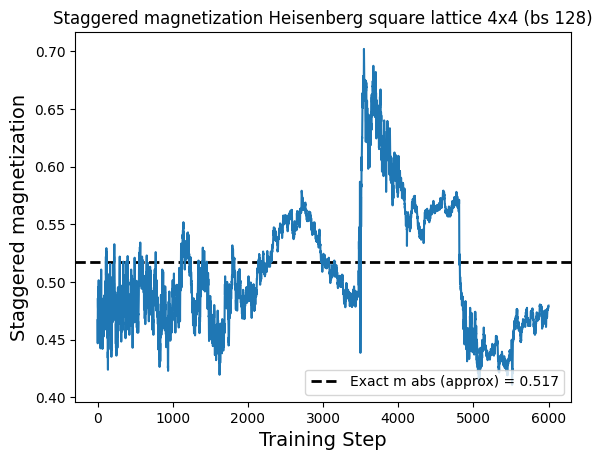

In [172]:

plt.title("Staggered magnetization Heisenberg square lattice 4x4 (bs 128)")
plt.axhline(quimb_m_stagg_abs, color='k', linestyle='--', linewidth=2,
           label=f"Exact m abs (approx) = {quimb_m_stagg_abs:.3f}")
plt.plot(run_maybe_lost['training/staggered_magnetization_absv2'].values[0][-6000:])
plt.legend(loc='lower right', fontsize=10)
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Stochastic Energy bs 128', fontsize=14)
plt.ylabel('Staggered magnetization', fontsize=14)

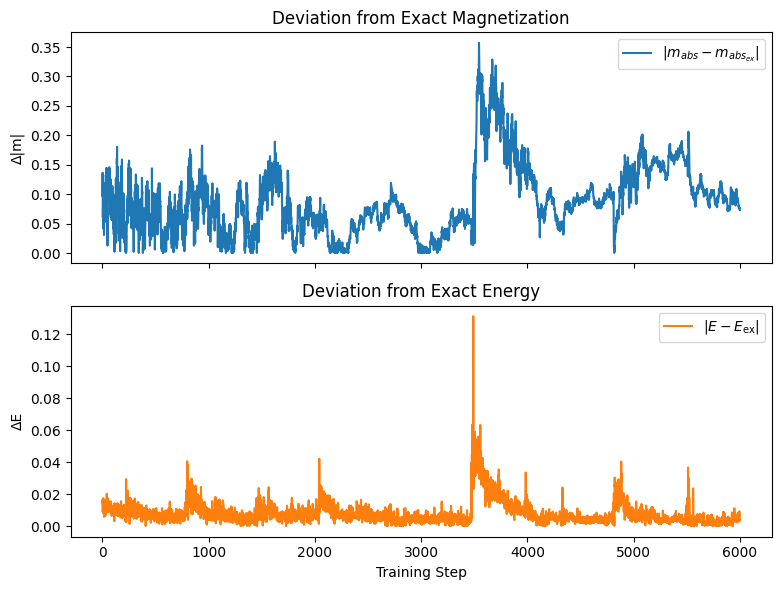

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Your data
mag    = run_maybe_lost['training/staggered_magnetization_absv2'].values[0][-6000:]
energy = run_maybe_lost['training/energy_real'].values[0][-6000:]

# 2) Exact refs
m_exact = quimb_m_stagg_abs
E_exact = ge[0][0]

steps       = np.arange(len(mag))
diff_mag    = np.abs(mag    - m_exact)/m_exact
diff_energy = np.abs(energy - E_exact)/np.abs(E_exact)

# 3) Create 2×1 axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# 4) Top: magnetization deviation
ax1.plot(steps, diff_mag,   label=r'$|m_{abs}-m_{abs_{ex}}|$')
ax1.set_ylabel("Δ|m|")
ax1.legend(loc="upper right")
ax1.set_title("Deviation from Exact Magnetization")

# 5) Bottom: energy deviation
ax2.plot(steps, diff_energy, color='C1', label=r'$| E - E_{\rm ex}|$')
ax2.set_ylabel("ΔE")
ax2.set_xlabel("Training Step")
ax2.legend(loc="upper right")
ax2.set_title("Deviation from Exact Energy")

plt.tight_layout()
plt.show()


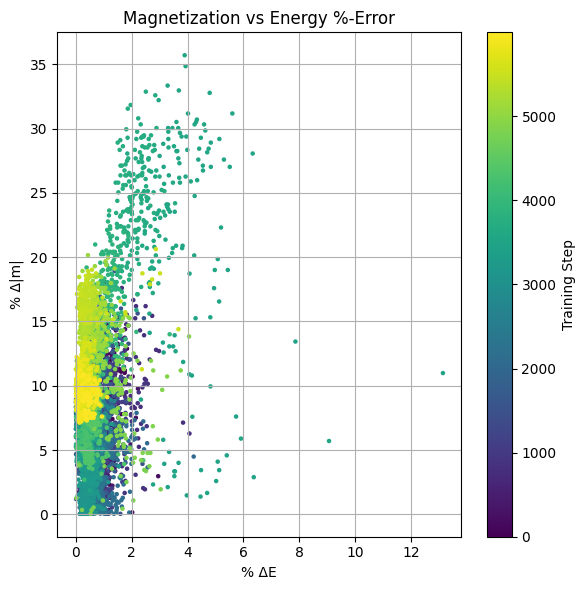

Corr(%ΔE, %Δm) = 0.41


In [162]:
import numpy as np
import matplotlib.pyplot as plt

# percent‐errors as above
pct_m = 100 * np.abs(mag - m_exact)   / m_exact
pct_E = 100 * np.abs(energy - E_exact) / abs(E_exact)

# 2D scatter, colored by training step
plt.figure(figsize=(6,6))
sc = plt.scatter(pct_E, pct_m, c=steps, s=5, cmap='viridis')
plt.colorbar(sc, label='Training Step')
plt.xlabel("% ΔE")
plt.ylabel("% Δ|m|")
plt.title("Magnetization vs Energy %-Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print correlation coefficient
corr = np.corrcoef(pct_E, pct_m)[0,1]
print(f"Corr(%ΔE, %Δm) = {corr:.2f}")


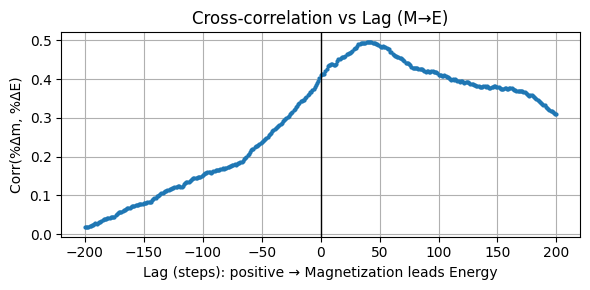

In [192]:
import numpy as np
import matplotlib.pyplot as plt

pct_m = 100 * np.abs(mag    - m_exact) / m_exact
pct_e = 100 * np.abs(energy - E_exact) / abs(E_exact)

max_lag = 200
lags    = np.arange(-max_lag, max_lag+1)
cc2     = []

for lag in lags:
    if lag < 0:
        # now: M leads E by -lag
        c = np.corrcoef(pct_m[:lag], pct_e[-lag:])[0,1]
    elif lag > 0:
        # now: M leads E by +lag
        c = np.corrcoef(pct_m[lag:], pct_e[:-lag])[0,1]
    else:
        c = np.corrcoef(pct_m, pct_e)[0,1]
    cc2.append(c)

plt.figure(figsize=(6,3))
plt.plot(lags, cc2, '.', ms=4)
plt.axvline(0, color='k', lw=1)
plt.xlabel("Lag (steps): positive → Magnetization leads Energy")
plt.ylabel("Corr(%Δm, %ΔE)")
plt.title("Cross-correlation vs Lag (M→E)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [191]:
mag

[0.466796875,
 0.45947265625,
 0.44677734375,
 0.4609375,
 0.48583984375,
 0.47900390625,
 0.47705078125,
 0.48828125,
 0.49560546875,
 0.45947265625,
 0.47216796875,
 0.47509765625,
 0.48388671875,
 0.48583984375,
 0.498046875,
 0.50146484375,
 0.49609375,
 0.48291015625,
 0.48779296875,
 0.462890625,
 0.4560546875,
 0.470703125,
 0.4638671875,
 0.47265625,
 0.4736328125,
 0.48974609375,
 0.4873046875,
 0.47021484375,
 0.48779296875,
 0.4755859375,
 0.458984375,
 0.4599609375,
 0.44873046875,
 0.45068359375,
 0.47119140625,
 0.46728515625,
 0.45458984375,
 0.45263671875,
 0.453125,
 0.4423828125,
 0.45068359375,
 0.4619140625,
 0.45703125,
 0.4599609375,
 0.466796875,
 0.4755859375,
 0.490234375,
 0.49267578125,
 0.5107421875,
 0.48486328125,
 0.4677734375,
 0.4609375,
 0.46044921875,
 0.46337890625,
 0.4609375,
 0.453125,
 0.46923828125,
 0.47216796875,
 0.458984375,
 0.4599609375,
 0.45556640625,
 0.451171875,
 0.45166015625,
 0.45068359375,
 0.453125,
 0.44189453125,
 0.45166015625

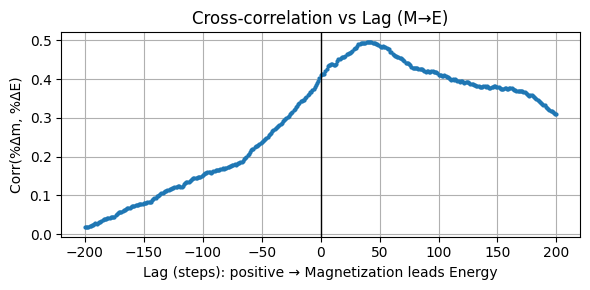

In [196]:
corr, cc= plot_cross_correlation_pct(mag, m_exact, energy, E_exact, max_lag=200)

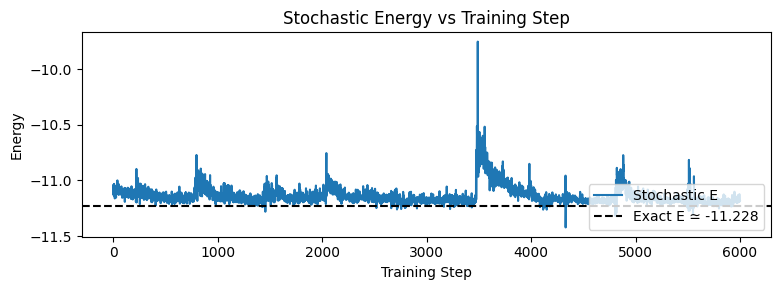

In [173]:
plot_energy(energy, E_exact, steps=steps, title="Stochastic Energy vs Training Step")

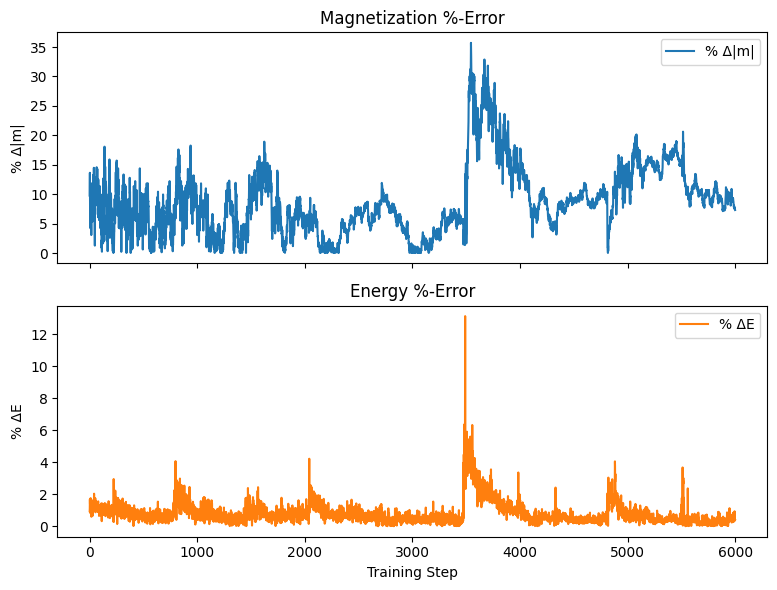

In [171]:
plot_deviation(mag=run_maybe_lost['training/staggered_magnetization_absv2'].values[0][-6000:],
               m_exact=quimb_m_stagg_abs,
               energy=run_maybe_lost['training/energy_real'].values[0][-6000:],
               E_exact=ge[0][0],
               steps=None,
               pct=True)

## Computational metrics

In [303]:
df_time_comp=pd.read_pickle(r"grid_nodelogin02_Tesla_T4_20250430-150957.pkl")

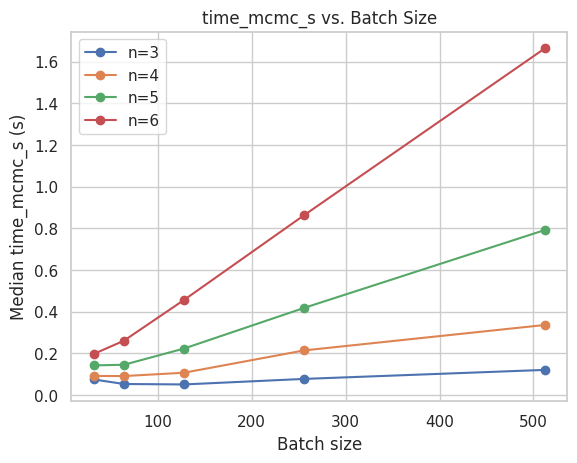

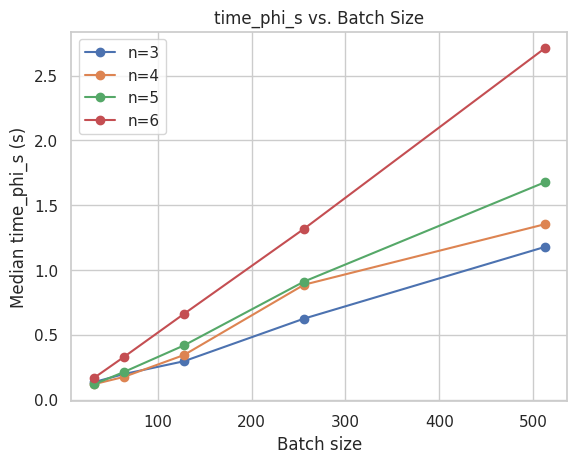

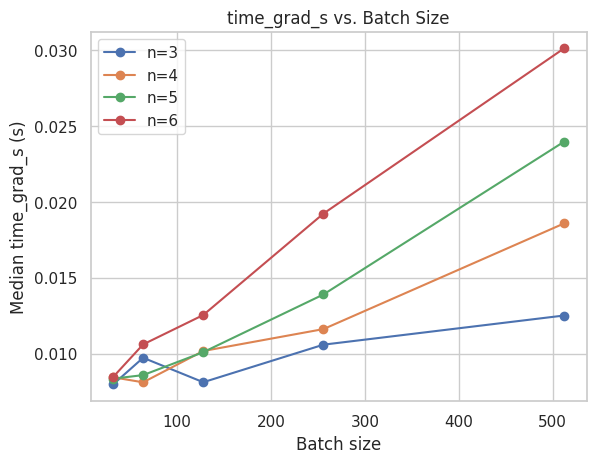

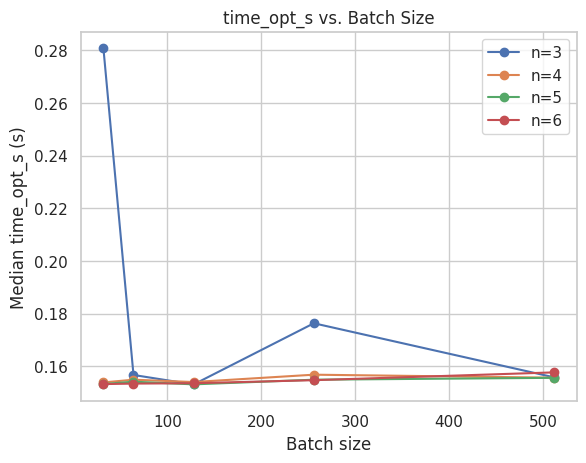

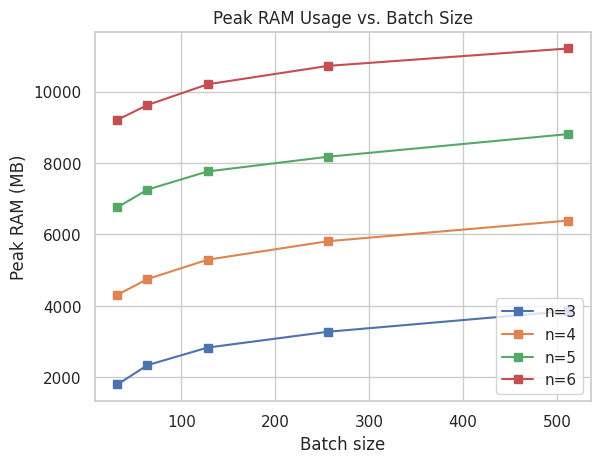

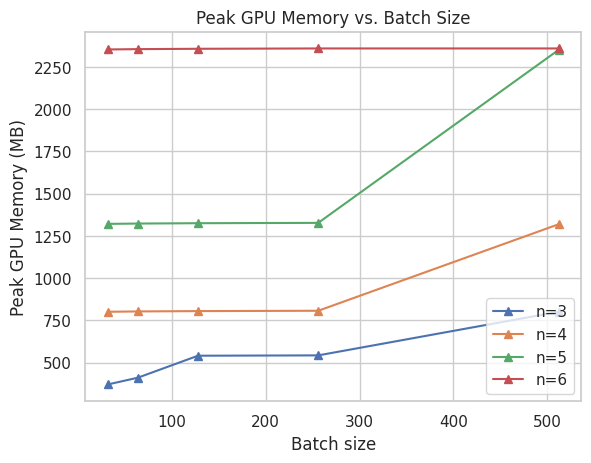

In [307]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_time_comp

# 2. Display a quick overview (excluding the energy column)
overview = df_time_comp.drop(columns=['energy_J_per_sample'])

# 3. Summary statistics for timing and memory
stats = overview.describe().T

# 4. Plot timing metrics vs. batch size for each lattice size
timing_metrics = ['time_mcmc_s', 'time_phi_s', 'time_grad_s', 'time_opt_s']
for metric in timing_metrics:
    plt.figure()
    for n in sorted(df['lattice_n'].unique()):
        sub = df[df['lattice_n'] == n].groupby('batch_size')[metric].median().reset_index()
        plt.plot(sub['batch_size'], sub[metric], marker='o', label=f'n={n}')
    plt.xlabel('Batch size')
    plt.ylabel(f'Median {metric} (s)')
    plt.title(f'{metric} vs. Batch Size')
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Plot RAM usage (end-of-iteration) vs. batch size
plt.figure()
for n in sorted(df['lattice_n'].unique()):
    sub = df[df['lattice_n'] == n].groupby('batch_size')['ram_end_MB'].max().reset_index()
    plt.plot(sub['batch_size'], sub['ram_end_MB'], marker='s', label=f'n={n}')
plt.xlabel('Batch size')
plt.ylabel('Peak RAM (MB)')
plt.title('Peak RAM Usage vs. Batch Size')
plt.legend()
plt.grid(True)
plt.show()

# 6. Plot GPU memory usage vs. batch size
plt.figure()
for n in sorted(df['lattice_n'].unique()):
    sub = df[df['lattice_n'] == n].groupby('batch_size')['gpu_mem_MB'].max().reset_index()
    plt.plot(sub['batch_size'], sub['gpu_mem_MB'], marker='^', label=f'n={n}')
plt.xlabel('Batch size')
plt.ylabel('Peak GPU Memory (MB)')
plt.title('Peak GPU Memory vs. Batch Size')
plt.legend()
plt.grid(True)
plt.show()




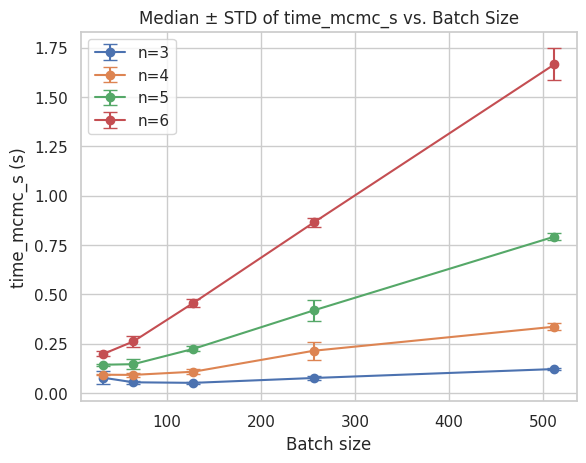

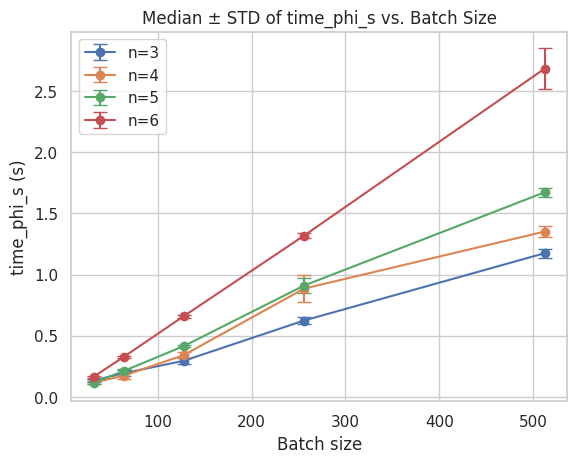

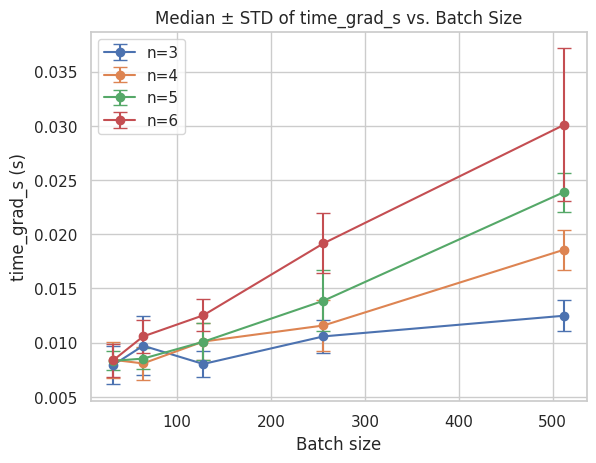

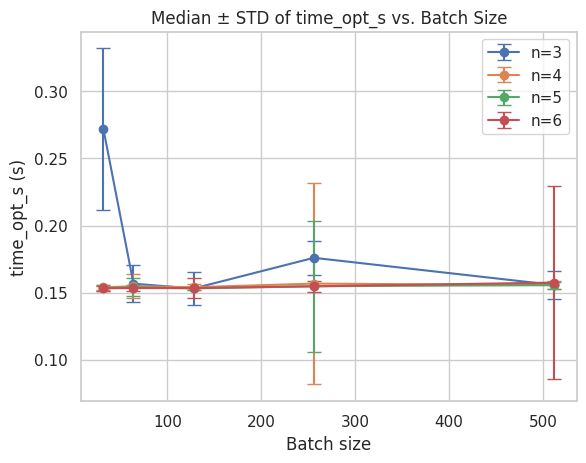

In [310]:
df_plot=df[df['iteration']>1]
for metric in timing_metrics:
    plt.figure()
    for n in sorted(df_plot['lattice_n'].unique()):
        sub = df_plot[df_plot['lattice_n'] == n].groupby('batch_size')[metric]
        median = sub.median()
        std = sub.std()
        plt.errorbar(
            median.index, median.values,
            yerr=std.values, fmt='-o',
            label=f'n={n}', capsize=5
        )
    plt.xlabel('Batch size')
    plt.ylabel(f'{metric} (s)')
    plt.title(f'Median ± STD of {metric} vs. Batch Size')
    plt.legend()
    plt.grid(True)
    plt.show()

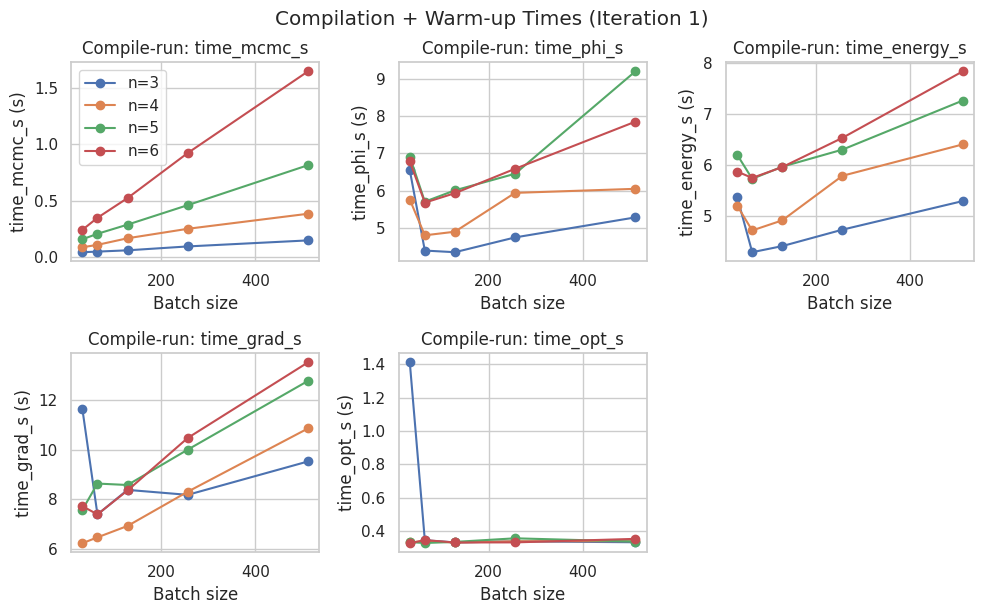

In [312]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the profiling data (update the path accordingly)
file_path = "/home/s3378209/data1/repfin/thesis_MSc/grid_nodelogin02_Tesla_T4_20250430-150957.pkl"
df = pd.read_pickle(file_path)

# Select only the first iteration (compile + warm-up)
df_compile = df[df['iteration'] == 1]

# Metrics to plot for compilation overhead
compile_metrics = ['time_mcmc_s', 'time_phi_s', 'time_energy_s', 'time_grad_s', 'time_opt_s']

# Plot each metric vs. batch size, with one line per lattice size
plt.figure(figsize=(10, 6))
for metric in compile_metrics:
    plt.subplot(2, 3, compile_metrics.index(metric) + 1)
    for n in sorted(df_compile['lattice_n'].unique()):
        sub = df_compile[df_compile['lattice_n'] == n].groupby('batch_size')[metric].first()
        plt.plot(sub.index, sub.values, marker='o', label=f'n={n}')
    plt.xlabel('Batch size')
    plt.ylabel(f'{metric} (s)')
    plt.title(f'Compile-run: {metric}')
    plt.grid(True)
    if compile_metrics.index(metric) == 0:
        plt.legend(loc='best')

plt.tight_layout()
plt.suptitle('Compilation + Warm-up Times (Iteration 1)', y=1.02)
plt.show()
